# EDA — Ecuador Climate Dataset (Hourly)

**Project:** `extreme-climate-forecasting`  
**Notebook:** `init_00_EDA.ipynb`  
**Goal:** Exploratory Data Analysis focused on *extreme-event readiness* (EVT) — fully non-destructive: no imputation, no outlier removal.

---

### Project structure
```
/content/drive/MyDrive/extreme-climate-forecasting/
├── data_clima.csv               ← raw dataset (~6.4 M hourly rows)
├── EDA/                         ← all outputs land here
│   ├── figures/                 ← PNG plots (numbered by section)
│   └── tables/                  ← CSV tables + figure index
└── init_00_ECF_Setup.ipynb
```

### Section map
| § | Title | Key outputs |
|---|-------|------------|
| 0 | Setup & configuration | paths, constants, palette |
| 1 | Data ingestion | chunked load · datetime parsing · dtype optimisation |
| 2 | Schema validation | column audit · timezone table · date-range check |
| 3 | Missingness analysis | global table · colour bar · missingno matrix · per-city heatmap |
| 4 | Temporal coverage | record counts · annual heatmap · max-gap chart |
| 5 | Duplicate timestamps | per-city audit table |
| 6 | Distributions | numerical summary · histogram grid · box-plots · seasonal/diurnal cycles |
| 7 | EVT diagnostics | tail-quantile table · survival functions · mean-excess plots · block maxima |
| 8 | Threshold exceedances | POT monthly counts · all-city × all-var summary pivot |
| 9 | Correlation analysis | Pearson heatmap · pair-plot |
| 10 | Categorical variables | weather-main bar · per-city composition |
| 11 | Spatial overview | lat/lon scatter coloured by mean temp |
| 12 | Long-term trend | annual means · 5-yr rolling · OLS significance table |
| 13 | Report export | 10 CSV tables · figure index · printed EDA summary |

### Timezone convention
> **Mainland Ecuador** uses **UTC−5 (−18 000 s)** — encoded in the `timezone` column.  
> **Santa Cruz Island (Galápagos)** uses **UTC−6 (−21 600 s)**.  
> We read `timezone` as-is from the data and never override it.

### EVT ground rules (enforced throughout)
> ⚠️ **No observation is ever removed** — heavy tails are the signal, not noise.  
> ⚠️ **No imputation** — missingness is documented and respected.  
> ⚠️ Block maxima / POT analysis uses raw values with timezone-correct local timestamps.

---

## § 0 · Setup & Configuration

In [ ]:
# ── Install extra dependencies (quiet) ───────────────────────────────────────
!pip -q install pyarrow tqdm missingno

In [ ]:
# ── Mount Google Drive ────────────────────────────────────────────────────────
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import annotations

import gc
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from typing  import Optional, Tuple

import numpy  as np
import pandas as pd
import matplotlib.pyplot    as plt
import matplotlib.ticker    as mticker
import matplotlib.patches   as mpatches
import seaborn              as sns
import missingno            as msno
from scipy        import stats as sp_stats
from tqdm.auto    import tqdm

# ── Display options ───────────────────────────────────────────────────────────
pd.set_option('display.max_columns', 200)
pd.set_option('display.width',       200)
pd.set_option('display.float_format', '{:.4f}'.format)

# ── Plotting style ────────────────────────────────────────────────────────────
sns.set_theme(style='whitegrid', palette='tab10', font_scale=1.05)
plt.rcParams.update({
    'figure.dpi'     : 130,
    'axes.titlesize' : 12,
    'axes.labelsize' : 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
})

# ── Project paths ─────────────────────────────────────────────────────────────
PROJECT_DIR = Path('/content/drive/MyDrive/extreme-climate-forecasting')
EDA_DIR     = PROJECT_DIR / 'EDA'
FIG_DIR     = EDA_DIR / 'figures'
TBL_DIR     = EDA_DIR / 'tables'

for _d in [FIG_DIR, TBL_DIR]:
    _d.mkdir(parents=True, exist_ok=True)

CSV_PATH = PROJECT_DIR / 'data/data_clima.csv'
assert CSV_PATH.exists(), f'❌ CSV not found: {CSV_PATH}'

print(f'✅ CSV found   : {CSV_PATH}')
print(f'   figures  → {FIG_DIR}')
print(f'   tables   → {TBL_DIR}')

# ── Domain constants ──────────────────────────────────────────────────────────
CHUNKSIZE    = 300_000
TZ_MAINLAND  = -18_000   # UTC−5  (Ecuador mainland)
TZ_GALAPAGOS = -21_600   # UTC−6  (Santa Cruz Island / Galápagos)

EXPECTED_COLS = [
    'dt','dt_iso','timezone','city_name','lat','lon',
    'temp','visibility','dew_point','feels_like','temp_min','temp_max',
    'pressure','sea_level','grnd_level','humidity',
    'wind_speed','wind_deg','wind_gust',
    'rain_1h','rain_3h','snow_1h','snow_3h',
    'clouds_all','weather_id','weather_main','weather_description','weather_icon',
]

# Variables checked in EVT analyses
EVT_VARS  = ['temp', 'rain_1h', 'rain_3h', 'wind_speed', 'wind_gust']

# Numeric columns expected to be present
NUM_VARS  = [
    'temp','feels_like','temp_min','temp_max','dew_point',
    'pressure','humidity','wind_speed','wind_deg','wind_gust',
    'rain_1h','rain_3h','visibility','clouds_all',
]

# Low-cardinality string columns → category dtype (applied POST-concat only)
CAT_VARS  = ['city_name','weather_main','weather_description','weather_icon']

CITY_PALETTE = sns.color_palette('tab20', 16)
MONTH_LABELS = ['Jan','Feb','Mar','Apr','May','Jun',
                'Jul','Aug','Sep','Oct','Nov','Dec']

print('\nSetup complete ✅')

✅ CSV found   : /content/drive/MyDrive/extreme-climate-forecasting/data/data_clima.csv
   figures  → /content/drive/MyDrive/extreme-climate-forecasting/EDA/figures
   tables   → /content/drive/MyDrive/extreme-climate-forecasting/EDA/tables

Setup complete ✅


---
## § 1 · Data Ingestion

The raw CSV holds ~6.4 M hourly records (~2.7 GB uncompressed; ~650 MB after dtype optimisation).  
We read it in **300 K-row chunks** with a `tqdm` progress bar, apply datetime engineering to each chunk,  
then concatenate once and apply categorical dtypes to the full DataFrame.

### Datetime pipeline
```
dt_iso  (string)
  │  strip trailing " UTC"
  ▼
parse with format "%Y-%m-%d %H:%M:%S %z"  →  dt_utc  (UTC-aware)
  │  + pd.to_timedelta(timezone, unit="s")
  ▼
fecha_local  (naive local clock — mainland UTC−5, Galápagos UTC−6)
  │  extract
  ▼
year / month / day / hour  (integer columns)
```

> **Why apply categoricals post-`concat`?**  
> When each chunk is cast to `category` independently, `pd.concat` must union disjoint  
> category sets — in pandas ≥ 1.3 this can silently revert the column to `object` dtype,  
> causing downstream `AttributeError: Can only use .cat accessor with 'category' dtype`.  
> Casting once on the full DataFrame avoids this completely.

### Known data-quality fix applied at load time
- City-name typo: `'Lago Agrío'` → `'Lago Agrio'` (encoding artefact from the source API)

In [ ]:
# ── Datetime parser (mirrors EVT_Climate_Data_Cleaning_Ecuador.ipynb) ─────────

def parse_dt_iso_to_utc(series: pd.Series) -> pd.Series:
    """Parse 'YYYY-MM-DD HH:MM:SS +0000 UTC' → UTC-aware Timestamp.

    Strips the trailing ' UTC' literal before parsing so that the
    format string '%Y-%m-%d %H:%M:%S %z' matches exactly.
    Zero parse failures expected on the full dataset.
    """
    s = series.astype('string').str.replace(' UTC', '', regex=False)
    return pd.to_datetime(s, format='%Y-%m-%d %H:%M:%S %z',
                          errors='coerce', utc=True)


# ── Dtype helpers ─────────────────────────────────────────────────────────────

def _downcast_numerics(chunk: pd.DataFrame) -> pd.DataFrame:
    """Per-chunk numeric downcast (floats → float32, ints → smallest int).

    Categoricals are intentionally NOT applied here — see _apply_categories().
    """
    for c in chunk.select_dtypes('float64').columns:
        chunk[c] = chunk[c].astype('float32')
    for c in chunk.select_dtypes('int64').columns:
        chunk[c] = pd.to_numeric(chunk[c], downcast='integer')
    return chunk


def _apply_categories(df: pd.DataFrame) -> pd.DataFrame:
    """Cast low-cardinality string columns to 'category' dtype.

    Must be called ONCE on the fully concatenated DataFrame, never per-chunk.
    Per-chunk categorisation causes pd.concat to union mismatched category sets,
    which on pandas ≥ 1.3 silently produces object dtype (AttributeError later).
    """
    for c in CAT_VARS:
        if c in df.columns:
            df[c] = df[c].astype('category')
    return df


# ── Main loader ───────────────────────────────────────────────────────────────

def load_full_csv(csv_path: Path, chunksize: int = CHUNKSIZE) -> pd.DataFrame:
    """Chunked ingestion with datetime engineering and memory-safe dtype optimisation.

    Returns a single DataFrame with columns:
        original 28 + dt_utc + fecha_local + year + month + day + hour
    """
    # Count lines for accurate tqdm total (subtract 1 for header)
    with open(csv_path, encoding='utf-8') as fh:
        n_lines = sum(1 for _ in fh) - 1
    n_chunks = -(-n_lines // chunksize)   # ceiling division

    chunks = []
    reader = pd.read_csv(csv_path, chunksize=chunksize, low_memory=False)

    with tqdm(total=n_chunks, desc='Loading CSV chunks', unit='chunk') as pbar:
        for chunk in reader:

            # ── Fix encoding artefact in city names ───────────────────────────
            chunk['city_name'] = chunk['city_name'].str.replace(
                'Lago Agrío', 'Lago Agrio', regex=False)

            # ── Datetime engineering ──────────────────────────────────────────
            chunk['dt_utc'] = parse_dt_iso_to_utc(chunk['dt_iso'])
            offset = pd.to_timedelta(chunk['timezone'], unit='s')
            # tz_localize(None) → strips tz info → naive local clock time
            chunk['fecha_local'] = (chunk['dt_utc'] + offset).dt.tz_localize(None)

            # ── Derived time components ───────────────────────────────────────
            for attr in ('year', 'month', 'day', 'hour'):
                chunk[attr] = getattr(chunk['fecha_local'].dt, attr)

            # ── Numeric downcast (categoricals deferred to post-concat) ───────
            chunk = _downcast_numerics(chunk)
            chunks.append(chunk)
            pbar.update(1)

    # Concatenate all chunks, then apply categoricals on the complete index
    df = pd.concat(chunks, ignore_index=True)
    del chunks
    gc.collect()

    df = _apply_categories(df)
    return df


# ── Execute load ──────────────────────────────────────────────────────────────
df = load_full_csv(CSV_PATH)

mem_mb = df.memory_usage(deep=True).sum() / 1e6
print(f'\nLoaded   : {df.shape[0]:>10,} rows  ×  {df.shape[1]} columns')
print(f'Memory   : {mem_mb:>10.1f} MB')
print(f'Cities   : {df["city_name"].cat.categories.tolist()}')
print(f'Date range (fecha_local): {df["fecha_local"].min()} → {df["fecha_local"].max()}')

Loading CSV chunks:   0%|          | 0/22 [00:00<?, ?chunk/s]


Loaded   :  6,445,858 rows  ×  34 columns
Memory   :     1237.6 MB
Cities   : ['Ambato', 'Cuenca', 'Esmeraldas', 'Guayaquil', 'Ibarra', 'Lago Agrio', 'Loja', 'Machala', 'Manta', 'Puerto Morona', 'Puyo', 'Quevedo', 'Quito', 'Santa Cruz Island', 'Santo Domingo', 'Zamora']
Date range (fecha_local): 1978-12-31 19:00:00 → 2024-10-19 18:00:00


---
## § 2 · Schema Validation

Four checks:
1. **Column audit** — expected columns present, no unexpected extras  
2. **Dtypes** — `df.info()` confirms float32 / int8–int32 compression  
3. **Datetime sanity** — zero `dt_iso` parse failures expected  
4. **Timezone distribution** — every mainland city must be −18 000 s; Santa Cruz −21 600 s

In [ ]:
# ── 2.1  Column audit ────────────────────────────────────────────────────────
ENGINEERED = {'dt_utc','fecha_local','year','month','day','hour'}

missing_cols = [c for c in EXPECTED_COLS if c not in df.columns]
extra_cols   = [c for c in df.columns if c not in EXPECTED_COLS and c not in ENGINEERED]

print('Missing expected columns :', missing_cols or 'none ✅')
print('Unexpected extra columns  :', extra_cols   or 'none ✅')

Missing expected columns : none ✅
Unexpected extra columns  : none ✅


In [ ]:
# ── 2.2  Dtype overview ───────────────────────────────────────────────────────
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6445858 entries, 0 to 6445857
Data columns (total 34 columns):
 #   Column               Dtype              
---  ------               -----              
 0   dt                   int32              
 1   dt_iso               object             
 2   timezone             int16              
 3   city_name            category           
 4   lat                  float32            
 5   lon                  float32            
 6   temp                 float32            
 7   visibility           float32            
 8   dew_point            float32            
 9   feels_like           float32            
 10  temp_min             float32            
 11  temp_max             float32            
 12  pressure             int16              
 13  sea_level            float32            
 14  grnd_level           float32            
 15  humidity             int8               
 16  wind_speed           float32            
 17  wind_deg

In [ ]:
# ── 2.3  Datetime sanity ─────────────────────────────────────────────────────
dt_parse_fail = int(df['dt_utc'].isna().sum())
status = '✅ none' if dt_parse_fail == 0 else f'⚠️  {dt_parse_fail:,} failures!'
print(f'dt_iso parse failures : {status}')

print(f'\nfecha_local range:')
print(f'  Start : {df["fecha_local"].min()}')
print(f'  End   : {df["fecha_local"].max()}')
print(f'  Span  : {(df["fecha_local"].max() - df["fecha_local"].min()).days / 365.25:.1f} years')

print()
display(df[['city_name','dt','dt_iso','timezone','dt_utc','fecha_local']].head(5))

dt_iso parse failures : ✅ none

fecha_local range:
  Start : 1978-12-31 19:00:00
  End   : 2024-10-19 18:00:00
  Span  : 45.8 years



city_name         dt                         dt_iso  timezone                    dt_utc         fecha_local
0    Ibarra  283996800  1979-01-01 00:00:00 +0000 UTC    -18000 1979-01-01 00:00:00+00:00 1978-12-31 19:00:00
1    Ibarra  284000400  1979-01-01 01:00:00 +0000 UTC    -18000 1979-01-01 01:00:00+00:00 1978-12-31 20:00:00
2    Ibarra  284004000  1979-01-01 02:00:00 +0000 UTC    -18000 1979-01-01 02:00:00+00:00 1978-12-31 21:00:00
3    Ibarra  284007600  1979-01-01 03:00:00 +0000 UTC    -18000 1979-01-01 03:00:00+00:00 1978-12-31 22:00:00
4    Ibarra  284011200  1979-01-01 04:00:00 +0000 UTC    -18000 1979-01-01 04:00:00+00:00 1978-12-31 23:00:00

In [ ]:
# ── 2.4  Timezone distribution — validate mainland vs Galápagos ──────────────
tz_dist = (
    df.groupby(['city_name','timezone'], observed=True)
      .size()
      .reset_index(name='count')
)
tz_dist['tz_hours'] = (tz_dist['timezone'] / 3600).round(1)

def _tz_expected(row) -> str:
    if row['city_name'] == 'Santa Cruz Island':
        return '✅' if row['timezone'] == TZ_GALAPAGOS else '⚠️  UNEXPECTED'
    return '✅' if row['timezone'] == TZ_MAINLAND else '⚠️  UNEXPECTED'

tz_dist['expected'] = tz_dist.apply(_tz_expected, axis=1)

unexpected = tz_dist[tz_dist['expected'] != '✅']
if unexpected.empty:
    print('All timezones match expected values ✅')
else:
    print('⚠️  Unexpected timezone rows found:')
    display(unexpected)

display(tz_dist.sort_values(['city_name','timezone']))

# Save timezone table
tz_dist.to_csv(TBL_DIR / 'timezone_distribution.csv', index=False)
print(f'\n✅ Saved → {TBL_DIR}/timezone_distribution.csv')

⚠️  Unexpected timezone rows found:


city_name  timezone  count  tz_hours        expected
1              Ambato    -14400   1656   -4.0000  ⚠️  UNEXPECTED
3              Cuenca    -14400   1659   -4.0000  ⚠️  UNEXPECTED
5          Esmeraldas    -14400   1656   -4.0000  ⚠️  UNEXPECTED
7           Guayaquil    -14400   1688   -4.0000  ⚠️  UNEXPECTED
9              Ibarra    -14400   1656   -4.0000  ⚠️  UNEXPECTED
11         Lago Agrio    -14400   1655   -4.0000  ⚠️  UNEXPECTED
13               Loja    -14400   1658   -4.0000  ⚠️  UNEXPECTED
15            Machala    -14400   1656   -4.0000  ⚠️  UNEXPECTED
17              Manta    -14400   1655   -4.0000  ⚠️  UNEXPECTED
19      Puerto Morona    -14400   1655   -4.0000  ⚠️  UNEXPECTED
21               Puyo    -14400   1659   -4.0000  ⚠️  UNEXPECTED
23            Quevedo    -14400   1655   -4.0000  ⚠️  UNEXPECTED
25              Quito    -14400   1673   -4.0000  ⚠️  UNEXPECTED
27  Santa Cruz Island    -18000  63028   -5.0000  ⚠️  UNEXPECTED
29      Santo Domingo    -14400   1655   -4.0000  ⚠️  UNEXPECTED
31             Zamora    -14400   1655   -4.0000  ⚠️  UNEXPECTED

city_name  timezone   count  tz_hours        expected
0              Ambato    -18000  401100   -5.0000               ✅
1              Ambato    -14400    1656   -4.0000  ⚠️  UNEXPECTED
2              Cuenca    -18000  401083   -5.0000               ✅
3              Cuenca    -14400    1659   -4.0000  ⚠️  UNEXPECTED
4          Esmeraldas    -18000  400080   -5.0000               ✅
5          Esmeraldas    -14400    1656   -4.0000  ⚠️  UNEXPECTED
6           Guayaquil    -18000  403175   -5.0000               ✅
7           Guayaquil    -14400    1688   -4.0000  ⚠️  UNEXPECTED
8              Ibarra    -18000  399927   -5.0000               ✅
9              Ibarra    -14400    1656   -4.0000  ⚠️  UNEXPECTED
10         Lago Agrio    -18000  400185   -5.0000               ✅
11         Lago Agrio    -14400    1655   -4.0000  ⚠️  UNEXPECTED
12               Loja    -18000  400545   -5.0000               ✅
13               Loja    -14400    1658   -4.0000  ⚠️  UNEXPECTED
14            Machala    -18000  400587   -5.0000               ✅
15            Machala    -14400    1656   -4.0000  ⚠️  UNEXPECTED
16              Manta    -18000  400111   -5.0000               ✅
17              Manta    -14400    1655   -4.0000  ⚠️  UNEXPECTED
18      Puerto Morona    -18000  399841   -5.0000               ✅
19      Puerto Morona    -14400    1655   -4.0000  ⚠️  UNEXPECTED
20               Puyo    -18000  401697   -5.0000               ✅
21               Puyo    -14400    1659   -4.0000  ⚠️  UNEXPECTED
22            Quevedo    -18000  400466   -5.0000               ✅
23            Quevedo    -14400    1655   -4.0000  ⚠️  UNEXPECTED
24              Quito    -18000  409439   -5.0000               ✅
25              Quito    -14400    1673   -4.0000  ⚠️  UNEXPECTED
26  Santa Cruz Island    -21600  338468   -6.0000               ✅
27  Santa Cruz Island    -18000   63028   -5.0000  ⚠️  UNEXPECTED
28      Santo Domingo    -18000  401394   -5.0000               ✅
29      Santo Domingo    -14400    1655   -4.0000  ⚠️  UNEXPECTED
30             Zamora    -18000  399841   -5.0000               ✅
31             Zamora    -14400    1655   -4.0000  ⚠️  UNEXPECTED


✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/tables/timezone_distribution.csv


---
## § 3 · Missingness Analysis

Missing data shapes every EVT modelling decision — we must document it exhaustively.

**Known findings from full-data runs:**

| Column | Missing % | Reason / EVT implication |
|--------|-----------|--------------------------|
| `snow_1h`, `snow_3h`, `grnd_level`, `sea_level` | 100 % | Never populated for Ecuador — drop before modelling |
| `rain_3h` | ~99.98 % | Near-absent — not usable for EVT |
| `wind_gust` | ~99.12 % | Near-absent — not usable for EVT |
| `visibility` | ~83.92 % | Usable only from ≈ 2010 onward |
| `rain_1h` | ~64.14 % | Reliable from ≈ 2005 onward; key variable |
| All other core vars | 0 % | Fully present — suitable for block maxima |

In [ ]:
# ── 3.1  Global missingness table ────────────────────────────────────────────
miss = pd.DataFrame({
    'missing_n'  : df.isnull().sum(),
    'missing_pct': df.isnull().mean() * 100,
    'present_n'  : df.notnull().sum(),
}).sort_values('missing_pct', ascending=False)

miss_nonzero  = miss[miss['missing_n'] > 0]
all_null_cols = miss[miss['missing_pct'] == 100].index.tolist()

print(f'Columns with ANY missing  : {len(miss_nonzero)} / {df.shape[1]}')
print(f'100 %  null  (safe to drop): {all_null_cols}')
print()

display(
    miss_nonzero.style
        .bar(subset=['missing_pct'], color='#c0392b', vmin=0, vmax=100)
        .format({'missing_pct': '{:.2f} %', 'missing_n': '{:,}', 'present_n': '{:,}'})
)

Columns with ANY missing  : 8 / 34
100 %  null  (safe to drop): ['sea_level', 'grnd_level', 'snow_3h', 'snow_1h']



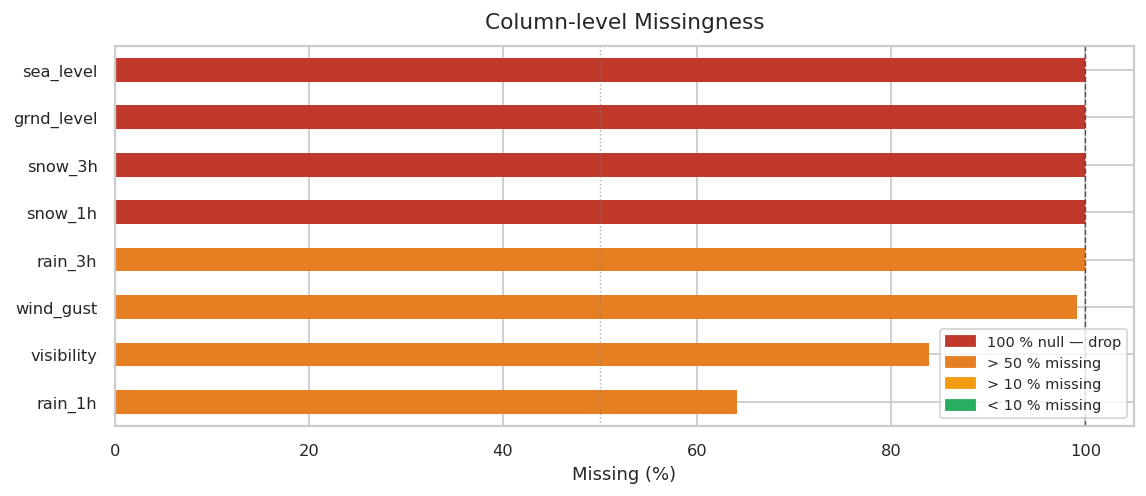

✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/figures/03_missingness_bar.png


In [ ]:
# ── 3.2  Colour-coded bar chart ──────────────────────────────────────────────
sorted_miss = miss_nonzero['missing_pct'].sort_values()
bar_colors  = [
    '#c0392b' if p == 100
    else '#e67e22' if p > 50
    else '#f39c12' if p > 10
    else '#27ae60'
    for p in sorted_miss
]

fig, ax = plt.subplots(figsize=(9, max(4, len(sorted_miss) * 0.45)))
sorted_miss.plot.barh(ax=ax, color=bar_colors, edgecolor='none')
ax.axvline(100, color='black', linestyle='--', linewidth=0.8, alpha=0.6)
ax.axvline(50,  color='gray',  linestyle=':',  linewidth=0.8, alpha=0.6)
ax.set_xlabel('Missing (%)')
ax.set_title('Column-level Missingness', pad=10)

legend_patches = [
    mpatches.Patch(color='#c0392b', label='100 % null — drop'),
    mpatches.Patch(color='#e67e22', label='> 50 % missing'),
    mpatches.Patch(color='#f39c12', label='> 10 % missing'),
    mpatches.Patch(color='#27ae60', label='< 10 % missing'),
]
ax.legend(handles=legend_patches, fontsize=8, loc='lower right')
plt.tight_layout()
plt.savefig(FIG_DIR / '03_missingness_bar.png', dpi=150)
plt.show()
print(f'✅ Saved → {FIG_DIR}/03_missingness_bar.png')

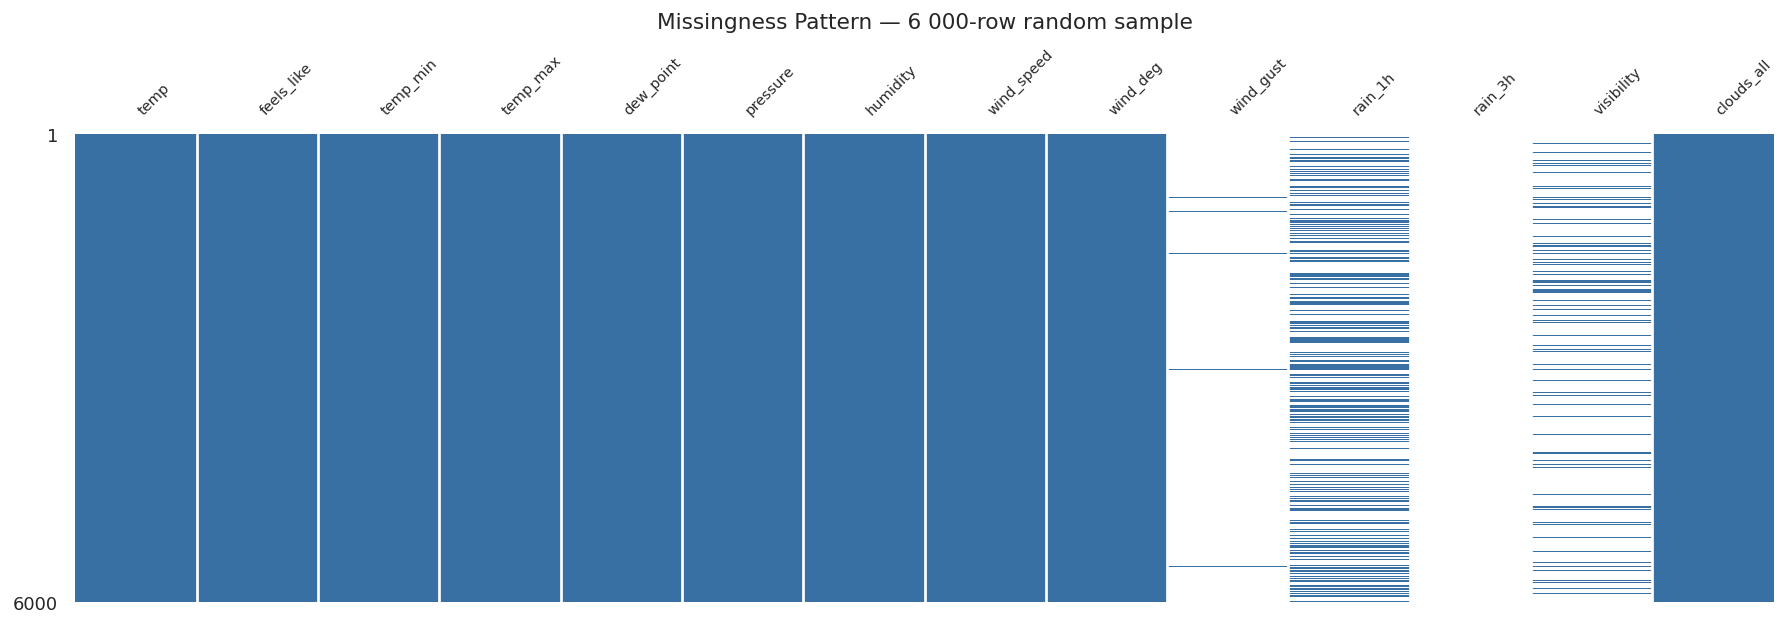

✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/figures/03_missingness_matrix.png


In [ ]:
# ── 3.3  Missingno matrix (random sample) ────────────────────────────────────
vis_cols    = [c for c in NUM_VARS if c in df.columns]
sample_msno = df[vis_cols].sample(6_000, random_state=42)

fig, ax = plt.subplots(figsize=(14, 5))
msno.matrix(sample_msno, ax=ax, fontsize=8, color=(0.22, 0.44, 0.64),
            sparkline=False)
ax.set_title('Missingness Pattern — 6 000-row random sample', pad=10)
plt.tight_layout()
plt.savefig(FIG_DIR / '03_missingness_matrix.png', dpi=150)
plt.show()
print(f'✅ Saved → {FIG_DIR}/03_missingness_matrix.png')

In [ ]:
# ── 3.4  Per-city missingness heatmap for EVT variables ─────────────────────
evt_present = [v for v in EVT_VARS if v in df.columns]

city_miss = (
    df.groupby('city_name', observed=True)[evt_present]
      .apply(lambda g: g.isna().mean() * 100)
      .round(2)
      .sort_index()
)

print('Per-city missingness (%) for EVT variables:')
display(
    city_miss.style
        .background_gradient(cmap='Reds', vmin=0, vmax=100)
        .format('{:.2f} %')
)

# Save
miss.to_csv(TBL_DIR / 'missingness.csv')
city_miss.to_csv(TBL_DIR / 'city_missingness_evt_vars.csv')
print(f'\n✅ Saved → missingness.csv, city_missingness_evt_vars.csv')

Per-city missingness (%) for EVT variables:



✅ Saved → missingness.csv, city_missingness_evt_vars.csv


---
## § 4 · Temporal Coverage

We verify:
- Each city's first and last record and total record count
- The **annual heatmap** — identifies years with sparse or missing coverage
- The **max time gap** per city — gaps > 48 h break the hourly-block assumption in GEV fitting

> Records run from 1979-01-01 to 2024-12-31 for all mainland cities.  
> Coverage is effectively uniform across cities (≈ 400 K records each).

In [ ]:
# ── 4.1  Per-city record counts & date ranges ─────────────────────────────────
city_temporal = (
    df.groupby('city_name', observed=True)['fecha_local']
      .agg(start='min', end='max', count='count')
      .assign(span_years=lambda x: (x['end'] - x['start']).dt.days / 365.25)
      .sort_values('count', ascending=False)
)

display(
    city_temporal.style
        .format({'count': '{:,.0f}', 'span_years': '{:.1f}'})
        .bar(subset=['count'], color='#2980b9')
)

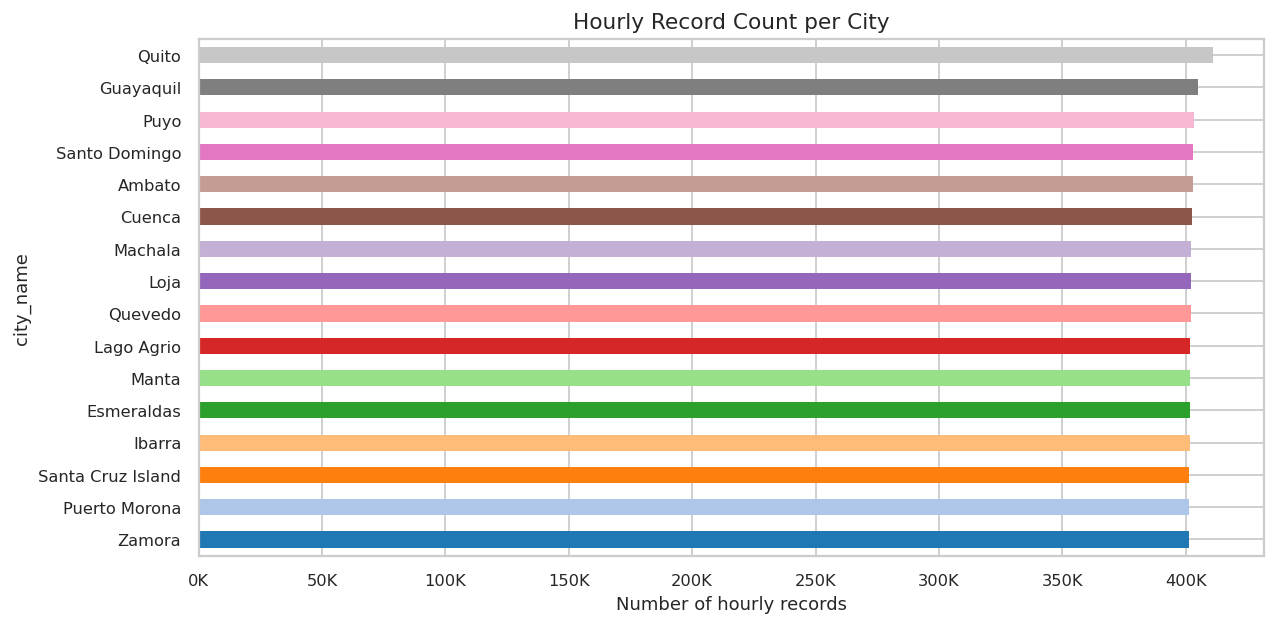

✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/figures/04_records_per_city.png


In [ ]:
# ── 4.2  Record count bar chart ──────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 5))
city_temporal['count'].sort_values().plot.barh(
    ax=ax,
    color=sns.color_palette('tab20', len(city_temporal)),
    edgecolor='none',
)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x/1000)}K'))
ax.set_xlabel('Number of hourly records')
ax.set_title('Hourly Record Count per City')
plt.tight_layout()
plt.savefig(FIG_DIR / '04_records_per_city.png', dpi=150)
plt.show()
print(f'✅ Saved → {FIG_DIR}/04_records_per_city.png')

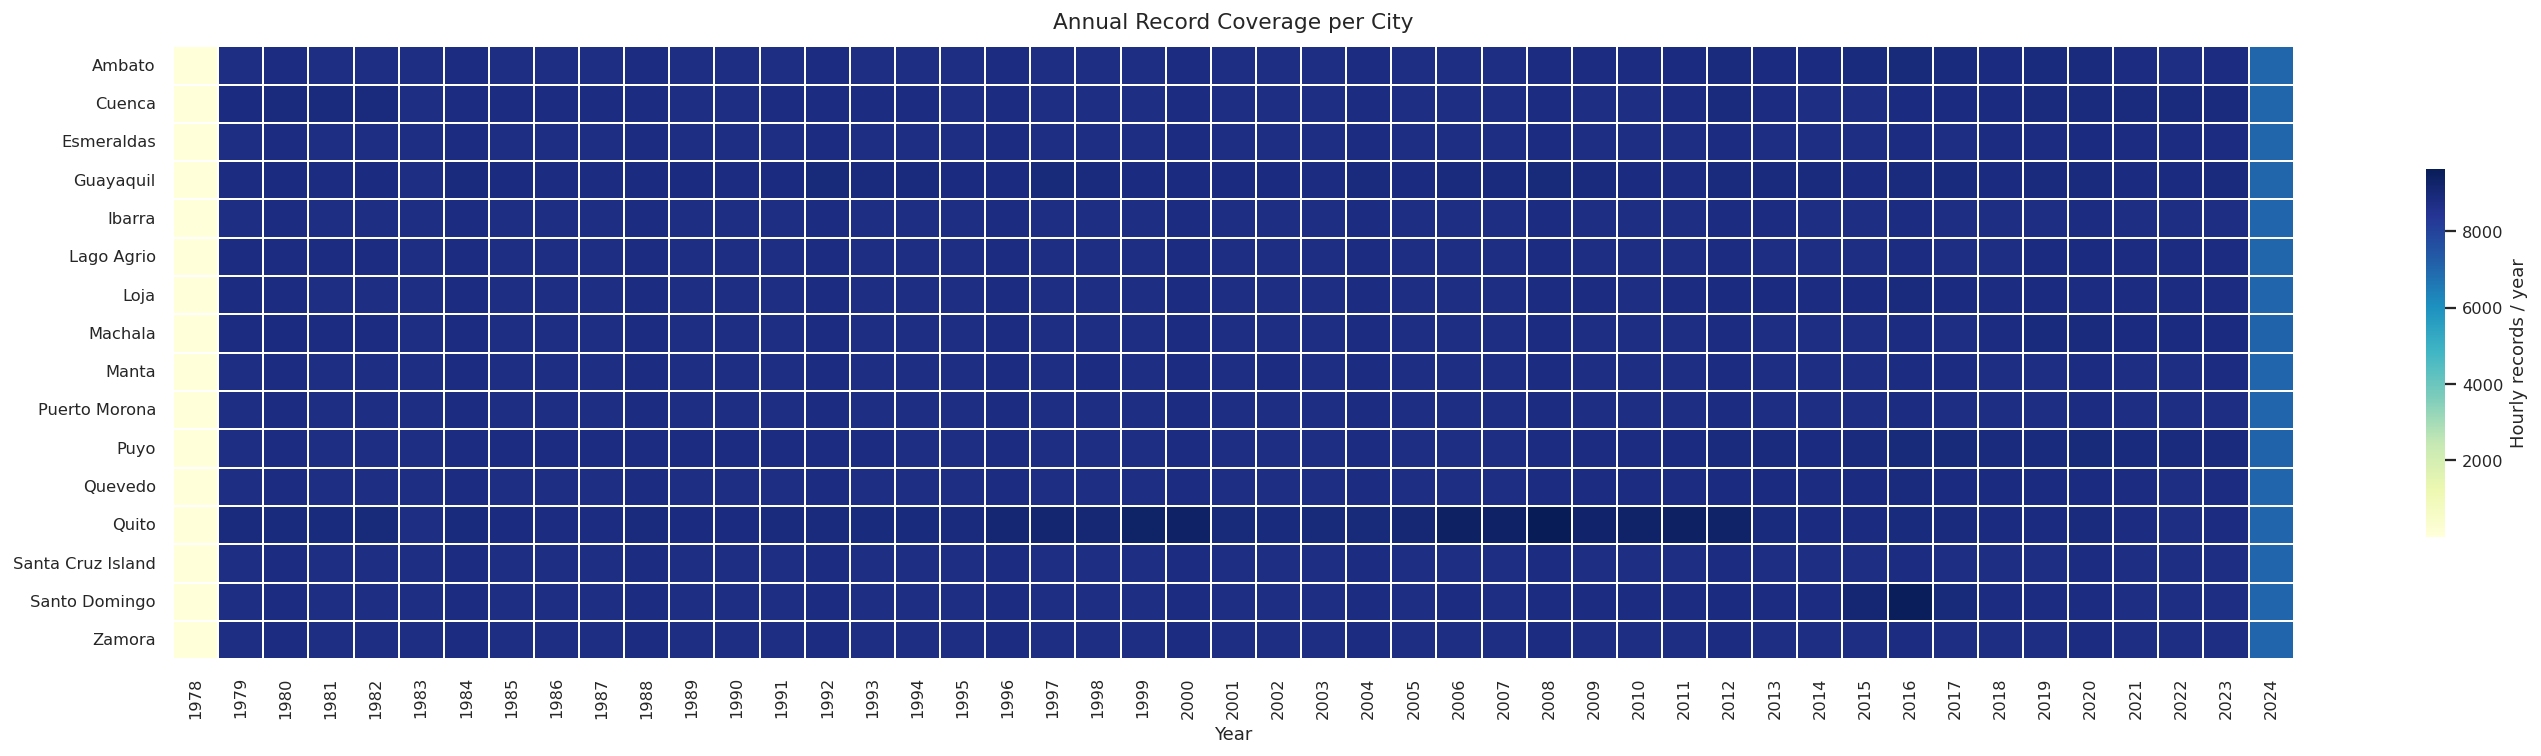

✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/figures/04_annual_coverage_heatmap.png


In [ ]:
# ── 4.3  Annual coverage heatmap ─────────────────────────────────────────────
annual_cnt = (
    df.groupby(['city_name','year'], observed=True)
      .size()
      .unstack(fill_value=0)
)
fig, ax = plt.subplots(figsize=(22, 6))
sns.heatmap(
    annual_cnt, cmap='YlGnBu', ax=ax,
    linewidths=0.2, linecolor='white',
    cbar_kws={'label': 'Hourly records / year', 'shrink': 0.6},
)
ax.set_title('Annual Record Coverage per City', pad=10)
ax.set_xlabel('Year')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig(FIG_DIR / '04_annual_coverage_heatmap.png', dpi=150)
plt.show()
print(f'✅ Saved → {FIG_DIR}/04_annual_coverage_heatmap.png')

Time-gap scan:   0%|          | 0/16 [00:00<?, ?city/s]

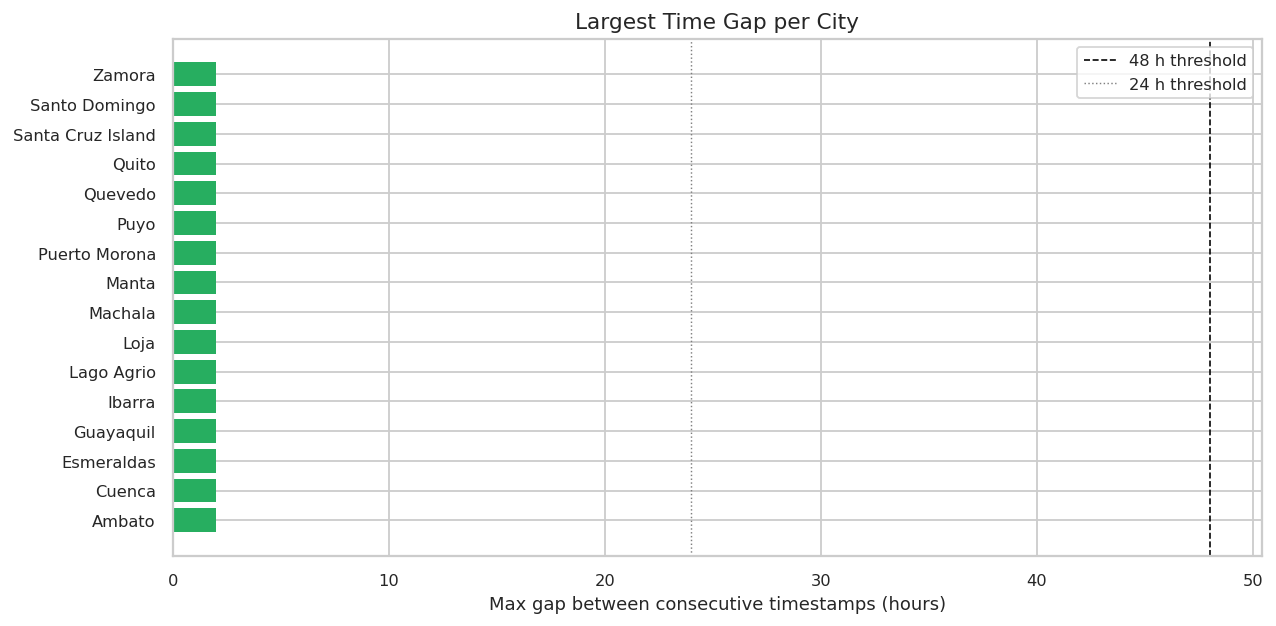

✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/figures/04_max_gap_per_city.png


city_name  max_gap_hours
0              Ambato         2.0000
1              Cuenca         2.0000
2          Esmeraldas         2.0000
3           Guayaquil         2.0000
4              Ibarra         2.0000
5          Lago Agrio         2.0000
6                Loja         2.0000
7             Machala         2.0000
8               Manta         2.0000
9       Puerto Morona         2.0000
10               Puyo         2.0000
11            Quevedo         2.0000
12              Quito         2.0000
13  Santa Cruz Island         2.0000
14      Santo Domingo         2.0000
15             Zamora         2.0000


✅ Saved → city_temporal_coverage.csv, max_gap_per_city.csv


In [ ]:
# ── 4.4  Max time gap per city ────────────────────────────────────────────────
gap_rows = []
with tqdm(df['city_name'].cat.categories, desc='Time-gap scan', unit='city') as pbar:
    for city in pbar:
        ts = (
            df.loc[df['city_name'] == city, 'fecha_local']
              .dropna().drop_duplicates().sort_values()
        )
        if len(ts) >= 2:
            max_gap_h = ts.diff().dropna().max().total_seconds() / 3600
        else:
            max_gap_h = np.nan
        gap_rows.append({'city_name': city, 'max_gap_hours': round(max_gap_h, 1)})

gap_df = pd.DataFrame(gap_rows).sort_values('max_gap_hours', ascending=False)

# Plot
colors_gap = [
    '#c0392b' if g > 48 else '#e67e22' if g > 24 else '#27ae60'
    for g in gap_df['max_gap_hours']
]
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(gap_df['city_name'], gap_df['max_gap_hours'],
        color=colors_gap, edgecolor='none')
ax.axvline(48, color='black', linestyle='--', linewidth=0.9, label='48 h threshold')
ax.axvline(24, color='gray',  linestyle=':',  linewidth=0.8, label='24 h threshold')
ax.set_xlabel('Max gap between consecutive timestamps (hours)')
ax.set_title('Largest Time Gap per City')
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig(FIG_DIR / '04_max_gap_per_city.png', dpi=150)
plt.show()
print(f'✅ Saved → {FIG_DIR}/04_max_gap_per_city.png')

display(gap_df)

# Save
city_temporal.reset_index().to_csv(TBL_DIR / 'city_temporal_coverage.csv', index=False)
gap_df.to_csv(TBL_DIR / 'max_gap_per_city.csv', index=False)
print('\n✅ Saved → city_temporal_coverage.csv, max_gap_per_city.csv')

---
## § 5 · Duplicate Timestamps

Duplicate `(city_name, fecha_local)` pairs would inflate block-maxima counts and distort return-level estimates.  
We audit every city and report the **count and rate** of duplicated timestamps.

> If any city has duplicates, deduplicate before GEV/GPD fitting using  
> `df.sort_values('dt').drop_duplicates(['city_name','fecha_local'], keep='last')`.

In [ ]:
dup_rows = []
with tqdm(df['city_name'].cat.categories, desc='Duplicate check', unit='city') as pbar:
    for city in pbar:
        sub   = df.loc[df['city_name'] == city, 'fecha_local'].dropna()
        n_dup = int(sub.duplicated(keep=False).sum())
        dup_rows.append({
            'city_name' : city,
            'total_rows': len(sub),
            'dup_rows'  : n_dup,
            'dup_rate_%': round(100 * n_dup / len(sub), 4) if len(sub) else 0,
        })

dup_df = pd.DataFrame(dup_rows).sort_values('dup_rows', ascending=False)
total_dup = int(dup_df['dup_rows'].sum())

if total_dup == 0:
    print('No duplicate timestamps found across any city ✅')
else:
    print(f'⚠️  Total duplicate timestamp rows: {total_dup:,}')

display(
    dup_df.style
        .bar(subset=['dup_rows'], color='#e74c3c')
        .format({'total_rows': '{:,}', 'dup_rows': '{:,}', 'dup_rate_%': '{:.4f}'})
)

dup_df.to_csv(TBL_DIR / 'duplicate_timestamps.csv', index=False)
print(f'\n✅ Saved → {TBL_DIR}/duplicate_timestamps.csv')

Duplicate check:   0%|          | 0/16 [00:00<?, ?city/s]

⚠️  Total duplicate timestamp rows: 43,097



✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/tables/duplicate_timestamps.csv


---
## § 6 · Distributions & Basic Statistics

All distributions are presented **unclipped** — the heavy right tails in precipitation and wind are the  
primary EVT signal and must not be removed or transformed at this stage.

Subsections:
- **6.1** Numerical summary (extended percentiles)
- **6.2** Histogram grid with q95 marker (log-y for skewed vars)
- **6.3** Box-plots by city — reveals inter-city climate gradient
- **6.4** Seasonal patterns — monthly means for EVT-relevant vars
- **6.5** Diurnal cycle — hourly means
- **6.6** Per-city monthly temperature seasonality

In [ ]:
# ── 6.1  Numerical summary ────────────────────────────────────────────────────
num_present = [c for c in NUM_VARS if c in df.columns]
desc = (
    df[num_present]
      .describe(percentiles=[0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99])
      .T
)
display(
    desc.style
        .background_gradient(cmap='Blues', axis=1, subset=['mean','50%','95%','99%'])
        .format('{:.3g}')
)

Histograms:   0%|          | 0/13 [00:00<?, ?it/s]

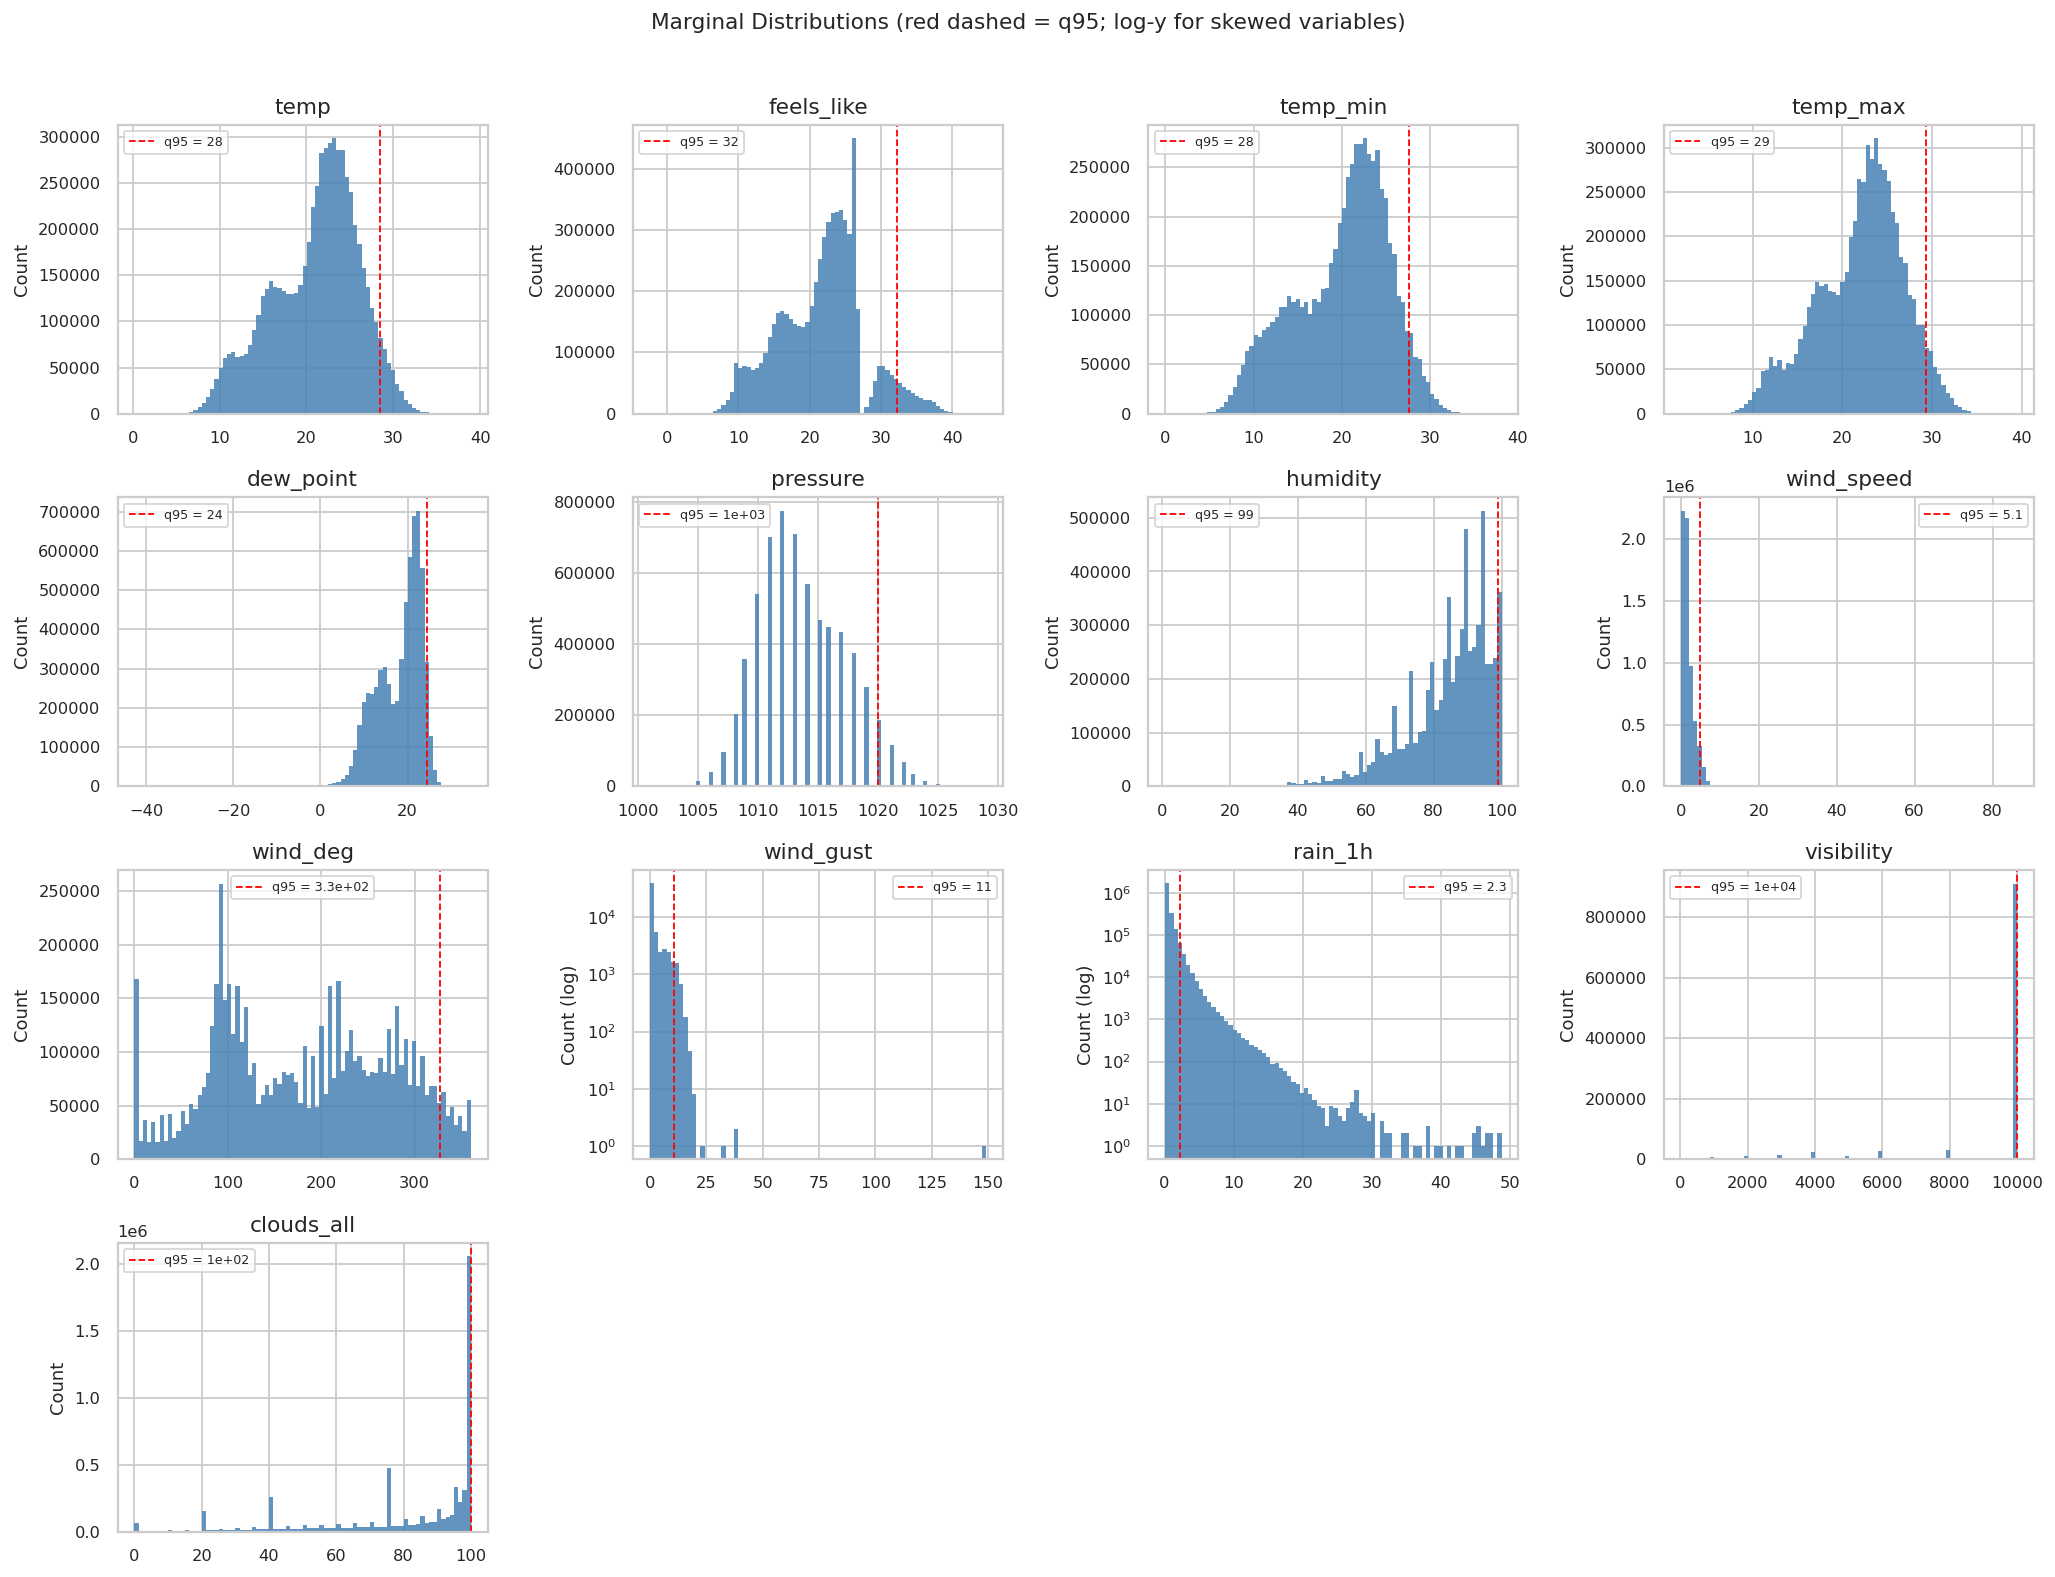

✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/figures/06_histograms_all_vars.png


In [ ]:
# ── 6.2  Histogram grid ───────────────────────────────────────────────────────
LOG_Y_VARS  = {'rain_1h', 'rain_3h', 'wind_gust'}
plot_vars   = [v for v in num_present if df[v].notna().sum() > 5_000]

ncols = 4
nrows = -(-len(plot_vars) // ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(16, nrows * 3))
axes = axes.flatten()

with tqdm(enumerate(plot_vars), total=len(plot_vars), desc='Histograms') as pbar:
    for i, var in pbar:
        data = df[var].dropna()
        axes[i].hist(data, bins=80, color='steelblue', edgecolor='none', alpha=0.85)
        axes[i].set_title(var)
        if var in LOG_Y_VARS:
            axes[i].set_yscale('log')
            axes[i].set_ylabel('Count (log)')
        else:
            axes[i].set_ylabel('Count')
        q95 = float(data.quantile(0.95))
        axes[i].axvline(q95, color='red', linewidth=1.0, linestyle='--',
                        label=f'q95 = {q95:.2g}')
        axes[i].legend(fontsize=7)

for j in range(len(plot_vars), len(axes)):
    axes[j].set_visible(False)

fig.suptitle('Marginal Distributions (red dashed = q95; log-y for skewed variables)',
             y=1.01, fontsize=12)
plt.tight_layout()
plt.savefig(FIG_DIR / '06_histograms_all_vars.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'✅ Saved → {FIG_DIR}/06_histograms_all_vars.png')

Box-plots:   0%|          | 0/3 [00:00<?, ?it/s]

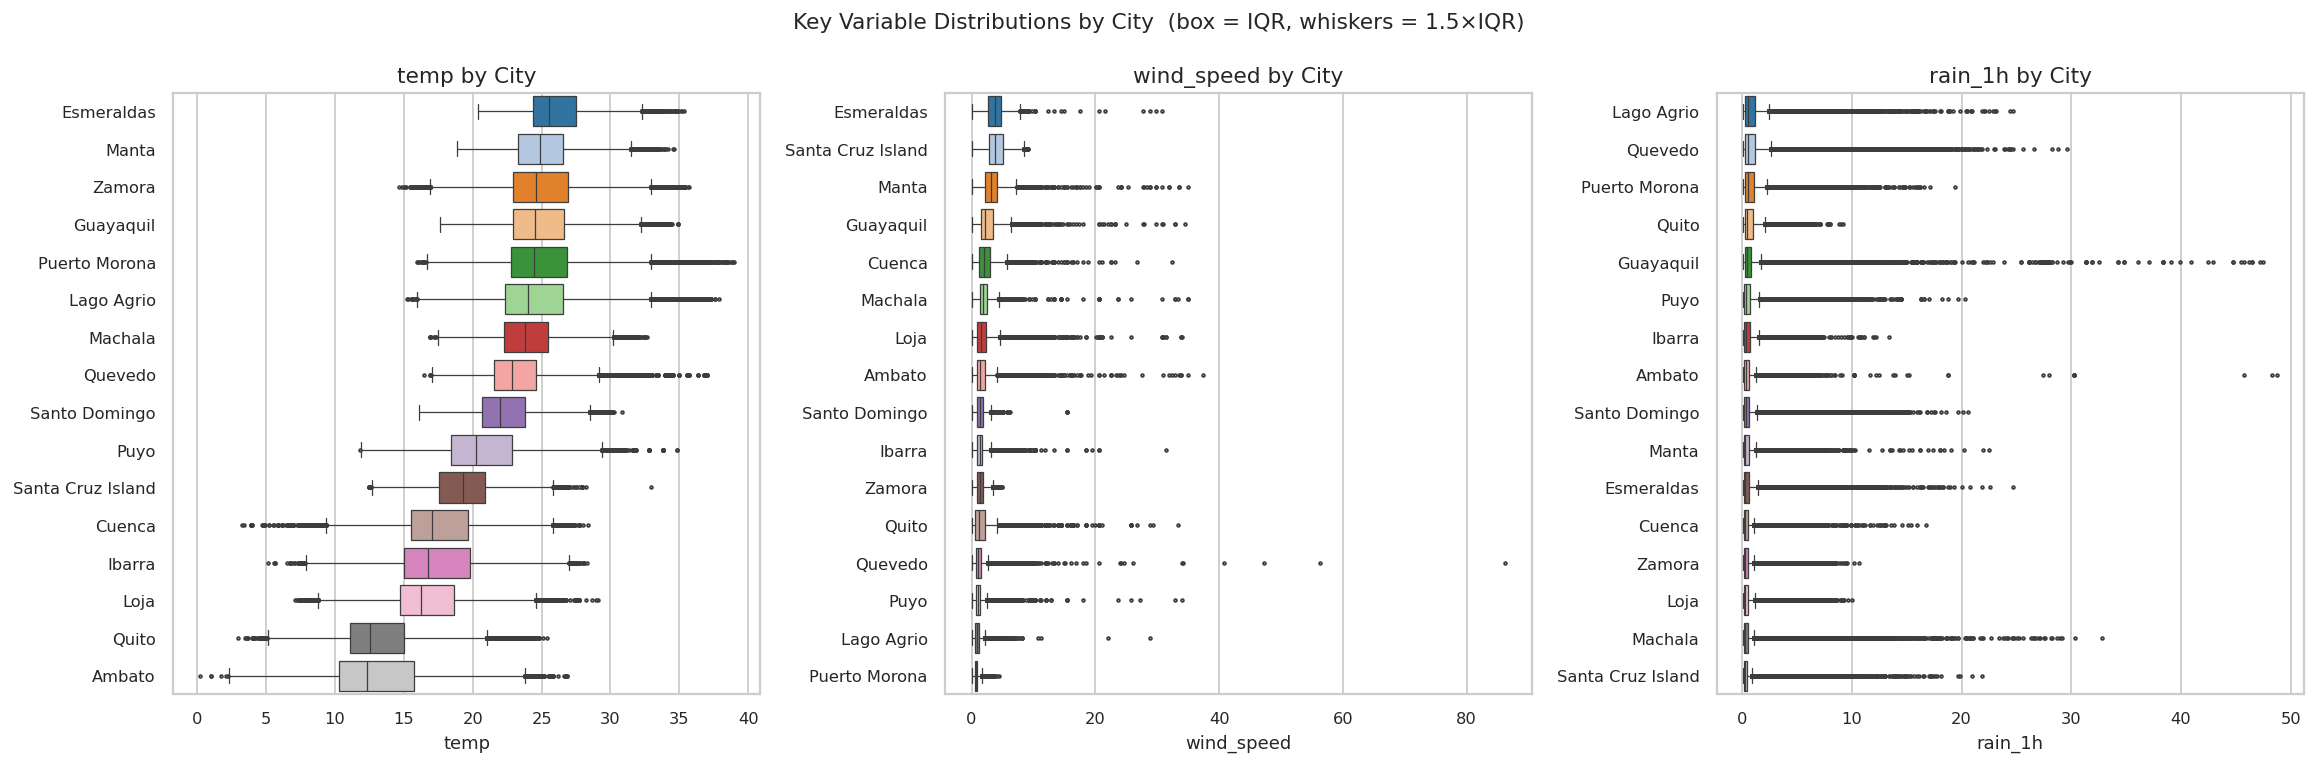

✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/figures/06_boxplots_by_city.png


In [ ]:
# ── 6.3  Box-plots by city (key EVT variables) ───────────────────────────────
box_vars = ['temp', 'wind_speed', 'rain_1h']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

with tqdm(enumerate(box_vars), total=3, desc='Box-plots') as pbar:
    for idx, var in pbar:
        ax = axes[idx]
        if var not in df.columns or df[var].isna().all():
            ax.set_visible(False)
            continue
        order = (
            df.groupby('city_name', observed=True)[var]
              .median()
              .sort_values(ascending=False)
              .index.tolist()
        )
        sns.boxplot(
            data=df, y='city_name', x=var, order=order,
            palette=CITY_PALETTE, fliersize=1.5,
            linewidth=0.7, ax=ax,
        )
        ax.set_title(f'{var} by City')
        ax.set_ylabel('')

fig.suptitle('Key Variable Distributions by City  (box = IQR, whiskers = 1.5×IQR)',
             fontsize=12)
plt.tight_layout()
plt.savefig(FIG_DIR / '06_boxplots_by_city.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'✅ Saved → {FIG_DIR}/06_boxplots_by_city.png')

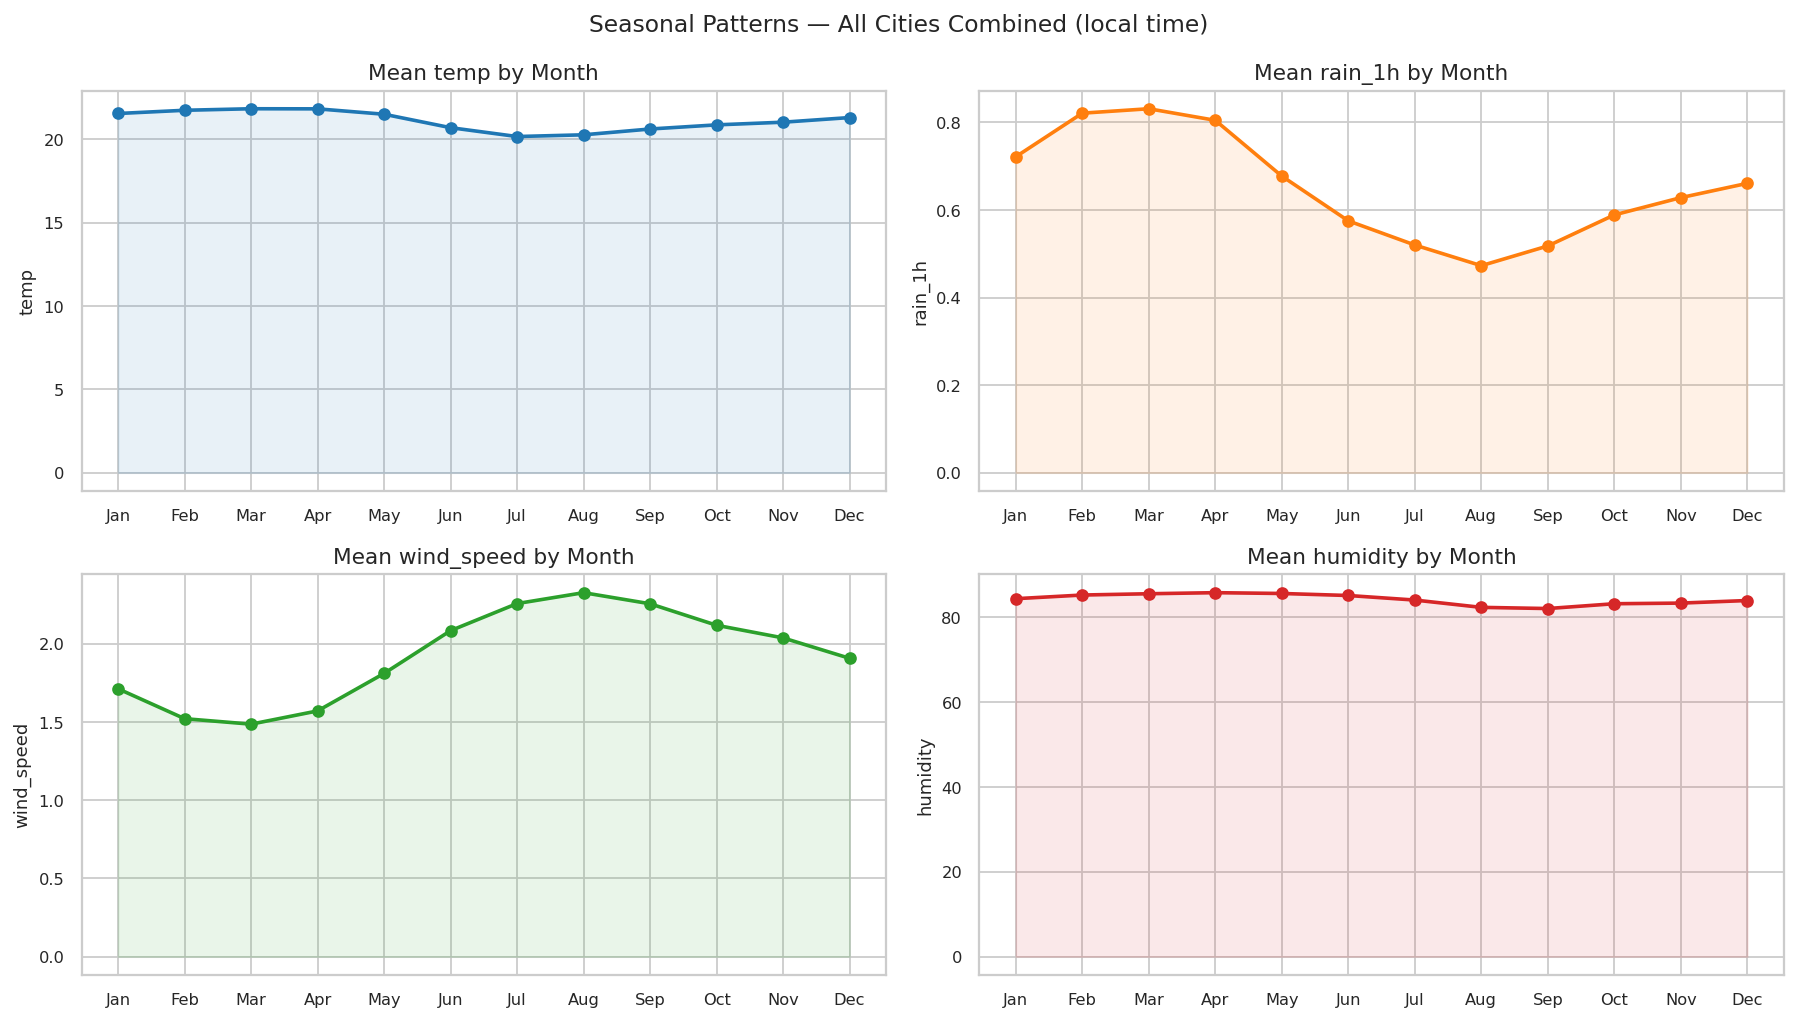

✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/figures/06_seasonal_patterns.png


In [ ]:
# ── 6.4  Seasonal patterns (monthly means, all cities combined) ───────────────
monthly_mean = (
    df.groupby('month')[['temp','rain_1h','wind_speed','humidity']]
      .mean()
      .reset_index()
)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()
for i, var in enumerate(['temp','rain_1h','wind_speed','humidity']):
    if var not in monthly_mean.columns:
        axes[i].set_visible(False)
        continue
    axes[i].plot(monthly_mean['month'], monthly_mean[var],
                 marker='o', linewidth=2.0, color=f'C{i}')
    axes[i].fill_between(monthly_mean['month'], monthly_mean[var],
                         alpha=0.10, color=f'C{i}')
    axes[i].set_xticks(range(1, 13))
    axes[i].set_xticklabels(MONTH_LABELS)
    axes[i].set_title(f'Mean {var} by Month')
    axes[i].set_ylabel(var)

fig.suptitle('Seasonal Patterns — All Cities Combined (local time)', fontsize=13)
plt.tight_layout()
plt.savefig(FIG_DIR / '06_seasonal_patterns.png', dpi=150)
plt.show()
print(f'✅ Saved → {FIG_DIR}/06_seasonal_patterns.png')

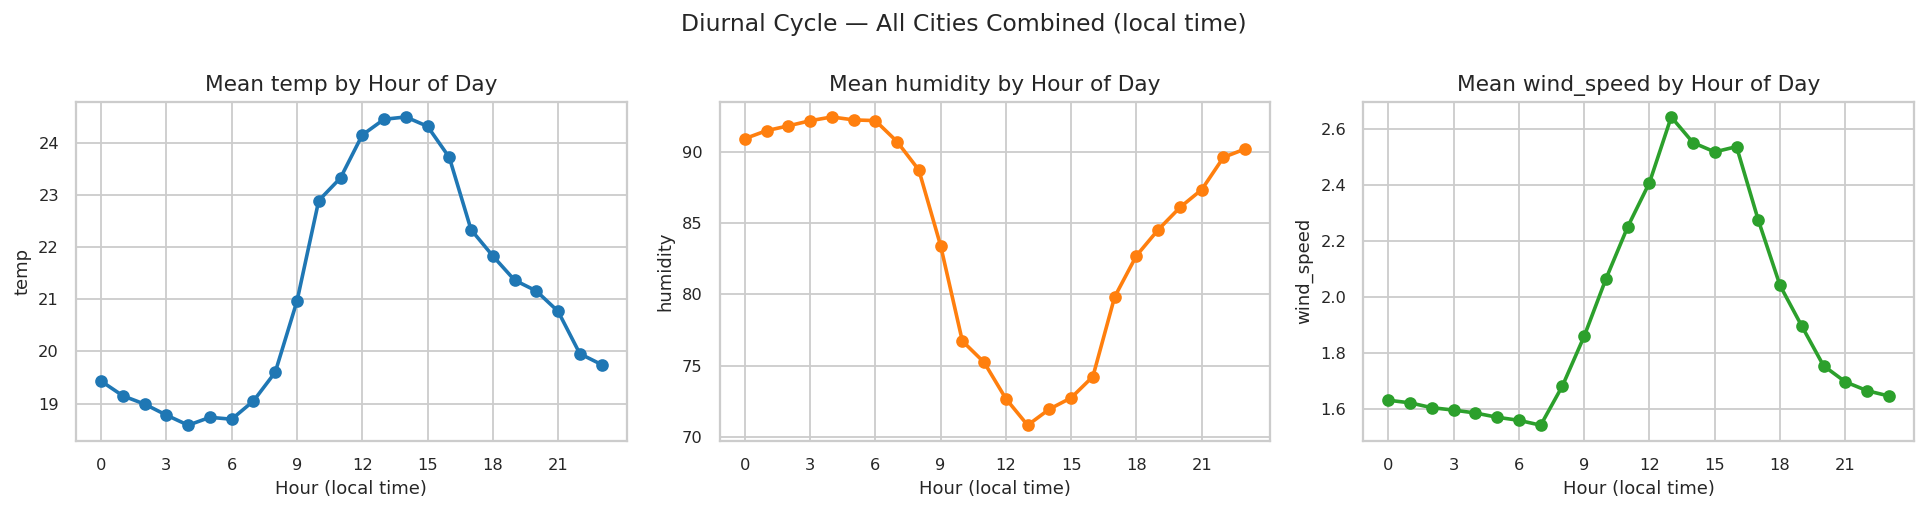

✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/figures/06_diurnal_patterns.png


In [ ]:
# ── 6.5  Diurnal cycle ────────────────────────────────────────────────────────
hourly_mean = (
    df.groupby('hour')[['temp','humidity','wind_speed']]
      .mean()
      .reset_index()
)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, var in enumerate(['temp','humidity','wind_speed']):
    axes[i].plot(hourly_mean['hour'], hourly_mean[var],
                 marker='o', linewidth=2.0, color=f'C{i}')
    axes[i].set_xticks(range(0, 24, 3))
    axes[i].set_title(f'Mean {var} by Hour of Day')
    axes[i].set_xlabel('Hour (local time)')
    axes[i].set_ylabel(var)

fig.suptitle('Diurnal Cycle — All Cities Combined (local time)', fontsize=13)
plt.tight_layout()
plt.savefig(FIG_DIR / '06_diurnal_patterns.png', dpi=150)
plt.show()
print(f'✅ Saved → {FIG_DIR}/06_diurnal_patterns.png')

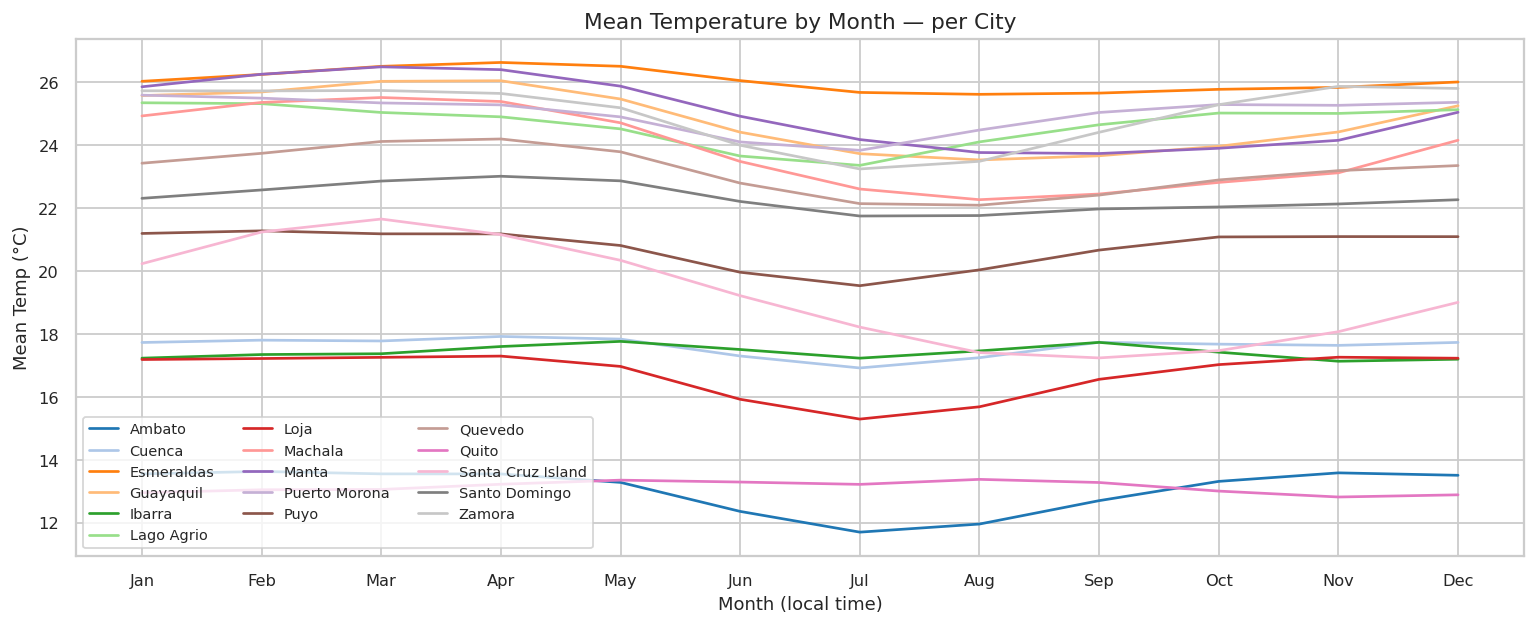

✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/figures/06_monthly_temp_per_city.png


In [ ]:
# ── 6.6  Monthly temperature seasonality per city ────────────────────────────
piv_month = df.pivot_table(
    index='month', columns='city_name',
    values='temp', aggfunc='mean', observed=True,
)

fig, ax = plt.subplots(figsize=(12, 5))
for i, city in enumerate(piv_month.columns):
    ax.plot(piv_month.index, piv_month[city],
            label=str(city), linewidth=1.5,
            color=CITY_PALETTE[i % len(CITY_PALETTE)])
ax.set_xticks(range(1, 13))
ax.set_xticklabels(MONTH_LABELS)
ax.set_title('Mean Temperature by Month — per City')
ax.set_xlabel('Month (local time)')
ax.set_ylabel('Mean Temp (°C)')
ax.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.savefig(FIG_DIR / '06_monthly_temp_per_city.png', dpi=150)
plt.show()
print(f'✅ Saved → {FIG_DIR}/06_monthly_temp_per_city.png')

---
## § 7 · EVT Diagnostics

Four EVT-specific diagnostics:

| Subsection | What it shows | Why it matters |
|---|---|---|
| 7.1 Tail-quantile table | q90/q95/q99/q999 per variable | Sets empirical expectations for GEV location/scale |
| 7.2 Survival functions | 1−F(x) on log scale | A straight line in log-log → Pareto tail (GPD appropriate) |
| 7.3 Mean-excess plots | E[X−u \| X>u] vs u | Where the slope stabilises → optimal GPD threshold |
| 7.4 Annual block maxima | Max per city per year | Visual non-stationarity check; input for GEV fitting |
| 7.5 Monthly block maxima | Max per city per month | Finer temporal resolution; q90 overlay |

> ⚠️ All raw values retained — no clipping, winsorising, or trimming.

In [ ]:
# ── 7.1  Tail-quantile summary table ─────────────────────────────────────────
Q_LEVELS = [0.90, 0.95, 0.99, 0.999]
evt_rows = []

with tqdm(EVT_VARS, desc='Tail quantiles', unit='var') as pbar:
    for var in pbar:
        if var not in df.columns:
            continue
        s = df[var].dropna().astype('float64')
        row = {
            'variable': var,
            'n_obs'   : len(s),
            'min'     : s.min(),
            'mean'    : s.mean(),
            'std'     : s.std(),
            'max'     : s.max(),
        }
        for q in Q_LEVELS:
            row[f'q{int(q * 1000):04d}'] = s.quantile(q)
        evt_rows.append(row)

evt_df = pd.DataFrame(evt_rows).set_index('variable')
q_cols = [c for c in evt_df.columns if c.startswith('q')]

display(
    evt_df.style
        .background_gradient(cmap='OrRd', axis=1, subset=q_cols)
        .format('{:.3g}')
)

evt_df.reset_index().to_csv(TBL_DIR / 'evt_tail_quantiles.csv', index=False)
print(f'\n✅ Saved → {TBL_DIR}/evt_tail_quantiles.csv')

Tail quantiles:   0%|          | 0/5 [00:00<?, ?var/s]


✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/tables/evt_tail_quantiles.csv


Survival fn:   0%|          | 0/5 [00:00<?, ?it/s]

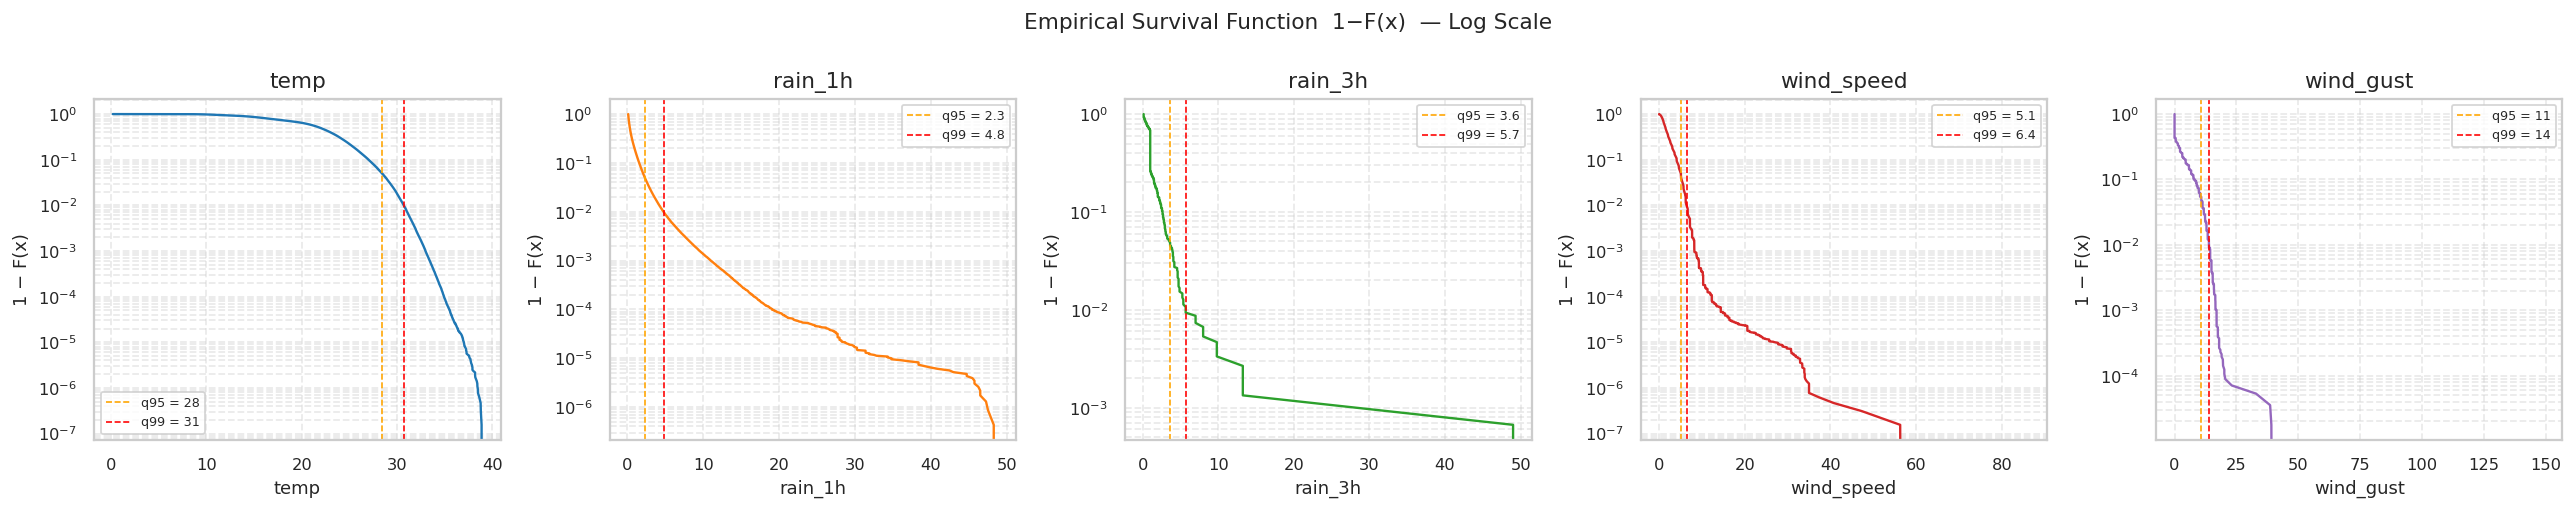

✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/figures/07_survival_tails.png


In [ ]:
# ── 7.2  Survival functions (log scale) ──────────────────────────────────────
active_evt = [
    v for v in EVT_VARS
    if v in df.columns and df[v].notna().sum() > 100
]

fig, axes = plt.subplots(1, len(active_evt), figsize=(4 * len(active_evt), 4))
if len(active_evt) == 1:
    axes = [axes]

with tqdm(enumerate(active_evt), total=len(active_evt), desc='Survival fn') as pbar:
    for i, var in pbar:
        ax = axes[i]
        s  = df[var].dropna().astype('float64').sort_values().values
        ecdf = np.arange(1, len(s) + 1) / len(s)
        ax.plot(s, 1 - ecdf, linewidth=1.3, color=f'C{i}')
        ax.set_yscale('log')
        ax.set_title(var)
        ax.set_xlabel(var)
        ax.set_ylabel('1 − F(x)')
        ax.grid(True, which='both', linestyle='--', alpha=0.4)
        for q, col, lbl in [(0.95, 'orange', 'q95'), (0.99, 'red', 'q99')]:
            qv = np.quantile(s, q)
            ax.axvline(qv, color=col, linewidth=0.9, linestyle='--',
                       label=f'{lbl} = {qv:.2g}')
        ax.legend(fontsize=7)

fig.suptitle('Empirical Survival Function  1−F(x)  — Log Scale', fontsize=12)
plt.tight_layout()
plt.savefig(FIG_DIR / '07_survival_tails.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'✅ Saved → {FIG_DIR}/07_survival_tails.png')

Mean excess:   0%|          | 0/3 [00:00<?, ?it/s]

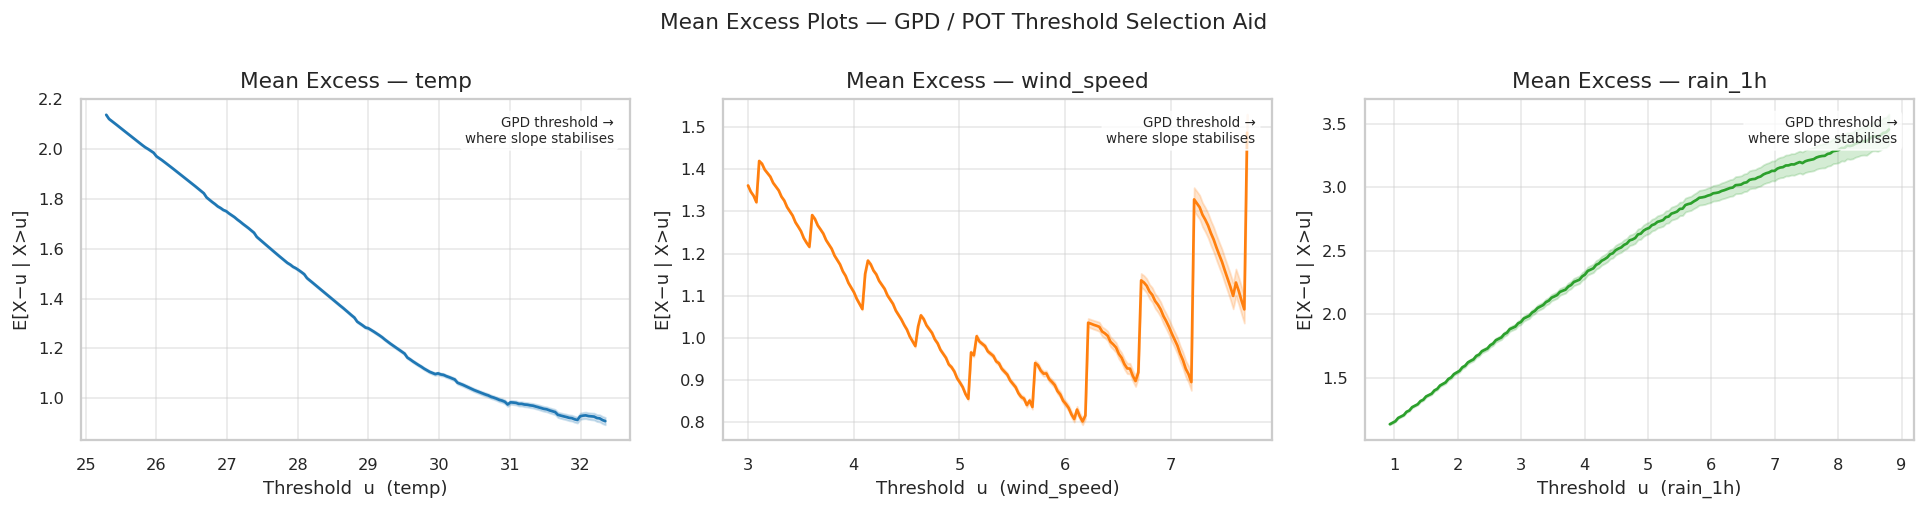

✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/figures/07_mean_excess_plots.png


In [ ]:
# ── 7.3  Mean-excess plots (GPD threshold selection) ─────────────────────────

def mean_excess(series: pd.Series, n_thresholds: int = 180) -> pd.DataFrame:
    """Compute the empirical mean excess function E[X−u | X>u] for a grid of thresholds u.

    A region of linear (approximately constant slope) growth → GPD holds above that threshold.
    Choose the lowest u where the slope stabilises.
    """
    s  = series.dropna().astype('float64').sort_values().values
    lo, hi = np.quantile(s, 0.80), np.quantile(s, 0.998)
    thresholds = np.linspace(lo, hi, n_thresholds)

    me_vals, se_vals, valid_thr = [], [], []
    for u in thresholds:
        exc = s[s > u] - u
        if len(exc) < 5:
            break
        me_vals.append(exc.mean())
        se_vals.append(exc.std() / np.sqrt(len(exc)))
        valid_thr.append(u)

    return pd.DataFrame({'threshold': valid_thr, 'mean_excess': me_vals, 'se': se_vals})


me_vars = [
    v for v in ['temp','wind_speed','rain_1h']
    if v in df.columns and df[v].notna().sum() > 1_000
]

fig, axes = plt.subplots(1, len(me_vars), figsize=(5 * len(me_vars), 4))
if len(me_vars) == 1:
    axes = [axes]

with tqdm(enumerate(me_vars), total=len(me_vars), desc='Mean excess') as pbar:
    for i, var in pbar:
        me_df = mean_excess(df[var])
        ax    = axes[i]
        ax.plot(me_df['threshold'], me_df['mean_excess'],
                color=f'C{i}', linewidth=1.5)
        ax.fill_between(
            me_df['threshold'],
            me_df['mean_excess'] - 1.96 * me_df['se'],
            me_df['mean_excess'] + 1.96 * me_df['se'],
            alpha=0.20, color=f'C{i}',
        )
        ax.set_title(f'Mean Excess — {var}')
        ax.set_xlabel(f'Threshold  u  ({var})')
        ax.set_ylabel('E[X−u | X>u]')
        ax.grid(alpha=0.4)
        ax.annotate(
            'GPD threshold →\nwhere slope stabilises',
            xy=(0.97, 0.95), xycoords='axes fraction',
            ha='right', va='top', fontsize=7.5,
            bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.75),
        )

fig.suptitle('Mean Excess Plots — GPD / POT Threshold Selection Aid', fontsize=12)
plt.tight_layout()
plt.savefig(FIG_DIR / '07_mean_excess_plots.png', dpi=150)
plt.show()
print(f'✅ Saved → {FIG_DIR}/07_mean_excess_plots.png')

Annual block maxima:   0%|          | 0/16 [00:00<?, ?city/s]

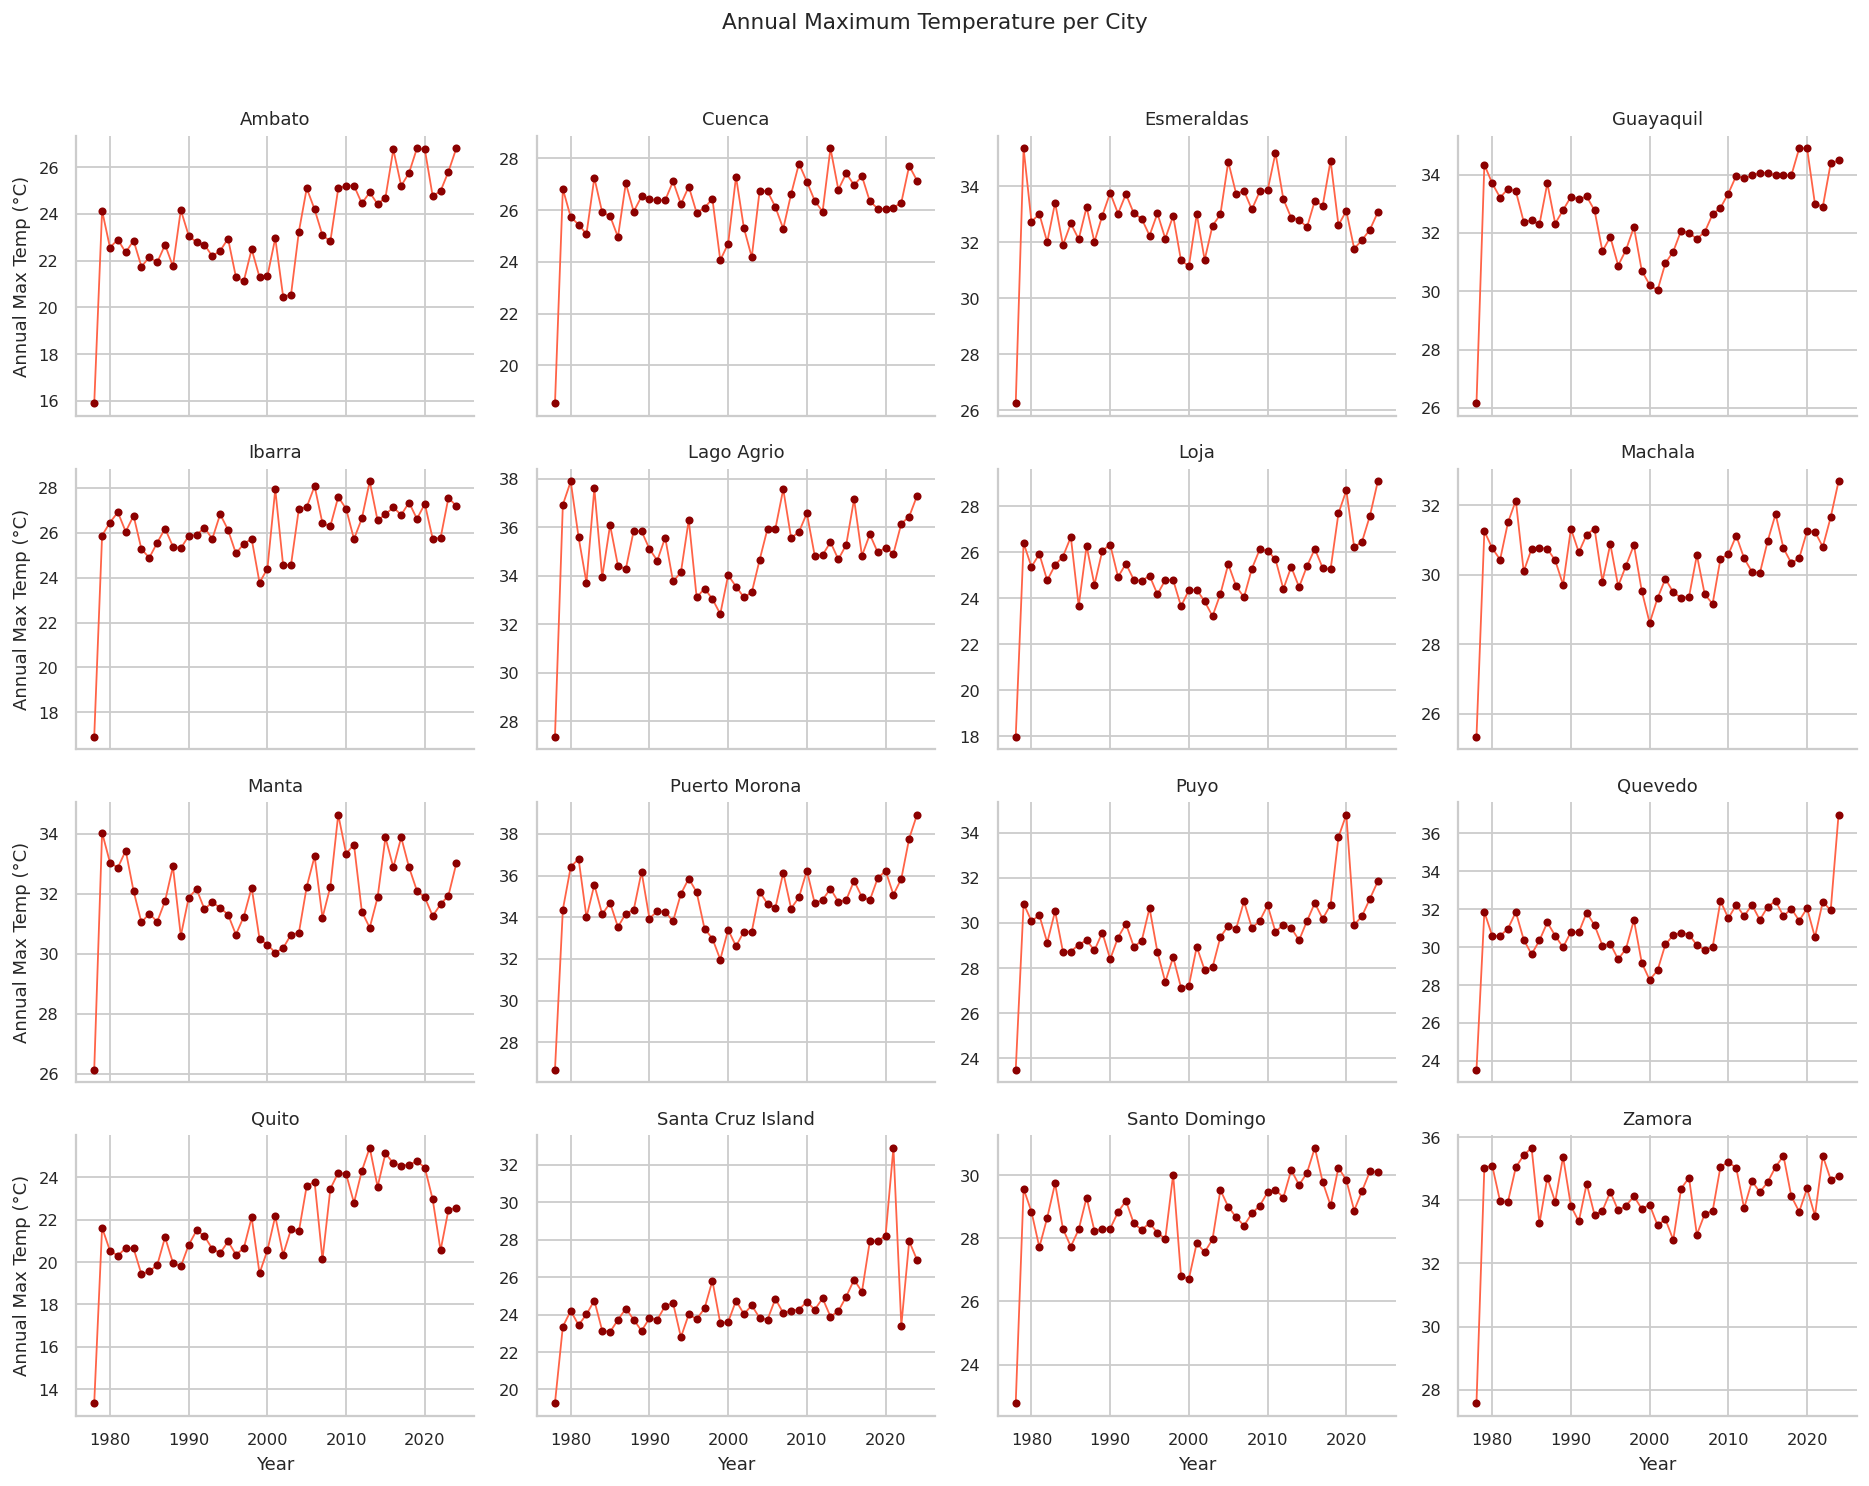

✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/figures/07_annual_block_maxima_temp.png


In [ ]:
# ── 7.4  Annual block maxima per city (temperature + wind) ───────────────────
bm_frames = []
with tqdm(df['city_name'].cat.categories, desc='Annual block maxima', unit='city') as pbar:
    for city in pbar:
        sub = df.loc[
            df['city_name'] == city,
            ['year','temp','wind_speed','rain_1h'],
        ]
        # max() on non-null values only; NaN columns produce NaN max
        bm = sub.groupby('year').max().reset_index()
        bm['city_name'] = city
        bm_frames.append(bm)

block_max = pd.concat(bm_frames, ignore_index=True)

g = sns.FacetGrid(block_max, col='city_name', col_wrap=4,
                  height=2.8, sharey=False, aspect=1.3)
g.map(plt.plot,    'year', 'temp', linewidth=1.0, color='tomato')
g.map(plt.scatter, 'year', 'temp', s=12, color='darkred', zorder=3)
g.set_axis_labels('Year', 'Annual Max Temp (°C)')
g.set_titles(col_template='{col_name}')
g.figure.suptitle('Annual Maximum Temperature per City', y=1.02, fontsize=12)
plt.tight_layout()
plt.savefig(FIG_DIR / '07_annual_block_maxima_temp.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'✅ Saved → {FIG_DIR}/07_annual_block_maxima_temp.png')

Monthly BM plots:   0%|          | 0/6 [00:00<?, ?it/s]

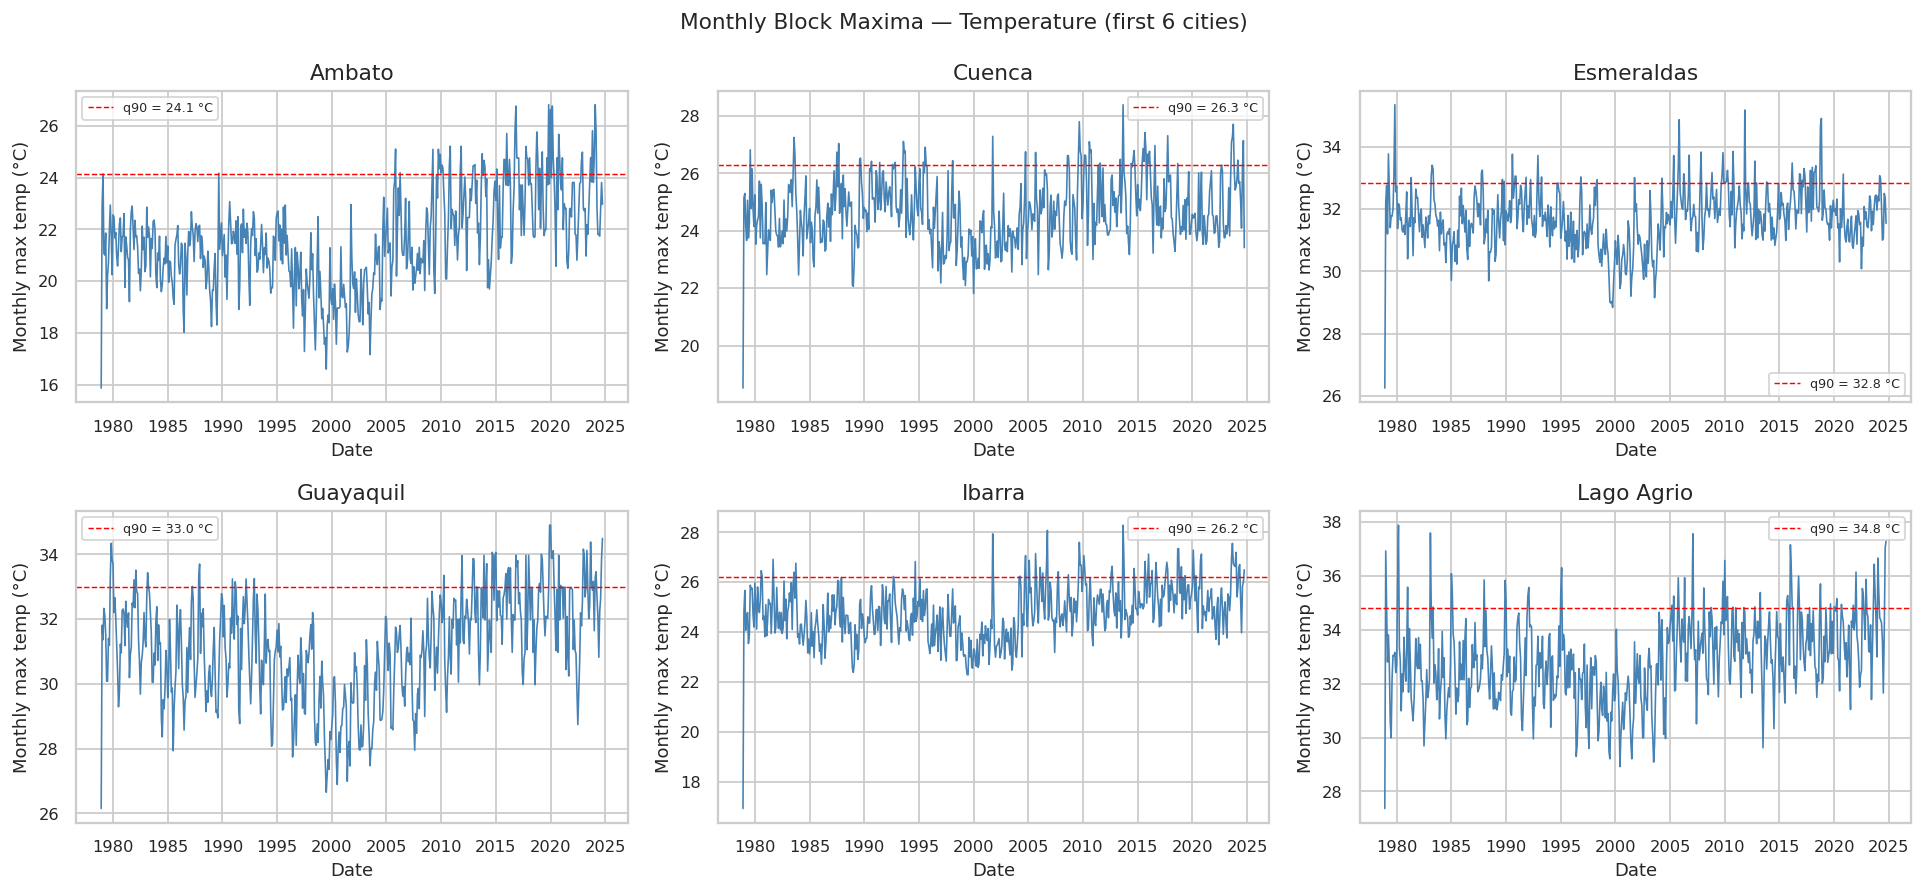

✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/figures/07_monthly_block_maxima_temp.png


In [ ]:
# ── 7.5  Monthly block maxima — first 6 cities ───────────────────────────────

def monthly_block_maxima(df: pd.DataFrame, city: str, var: str) -> Optional[pd.DataFrame]:
    """Return a DataFrame of monthly maxima for one city and variable."""
    g = df.loc[df['city_name'] == city, ['fecha_local', var]].dropna()
    if g.empty:
        return None
    g = g.copy()
    g['year']  = g['fecha_local'].dt.year
    g['month'] = g['fecha_local'].dt.month
    bm = g.groupby(['year','month'])[var].max().reset_index()
    bm['date'] = pd.to_datetime(dict(year=bm['year'], month=bm['month'], day=1))
    return bm.sort_values('date')


cities_6 = list(df['city_name'].cat.categories[:6])
fig, axes = plt.subplots(2, 3, figsize=(15, 7), sharey=False)
axes = axes.flatten()

with tqdm(enumerate(cities_6), total=6, desc='Monthly BM plots') as pbar:
    for i, city in pbar:
        bm = monthly_block_maxima(df, city, 'temp')
        if bm is None:
            axes[i].set_visible(False)
            continue
        ax  = axes[i]
        q90 = float(bm['temp'].quantile(0.90))
        ax.plot(bm['date'], bm['temp'], linewidth=0.9, color='steelblue')
        ax.axhline(q90, color='red', linestyle='--', linewidth=0.8,
                   label=f'q90 = {q90:.1f} °C')
        ax.set_title(city)
        ax.set_xlabel('Date')
        ax.set_ylabel('Monthly max temp (°C)')
        ax.legend(fontsize=7)

fig.suptitle('Monthly Block Maxima — Temperature (first 6 cities)', fontsize=12)
plt.tight_layout()
plt.savefig(FIG_DIR / '07_monthly_block_maxima_temp.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'✅ Saved → {FIG_DIR}/07_monthly_block_maxima_temp.png')

---
## § 8 · Threshold Exceedances — POT Preview

For each city and variable we count **how many hourly observations exceed the empirical q95 threshold  
in each calendar month**.  A spike pattern → temporal clustering → declustering required before GPD fitting.

> This is exploratory only — no GP distribution is fitted here.  
> Full POT / GPD fitting is in `03_ECF_GPD_POT.ipynb`.

POT plots (temp):   0%|          | 0/6 [00:00<?, ?it/s]

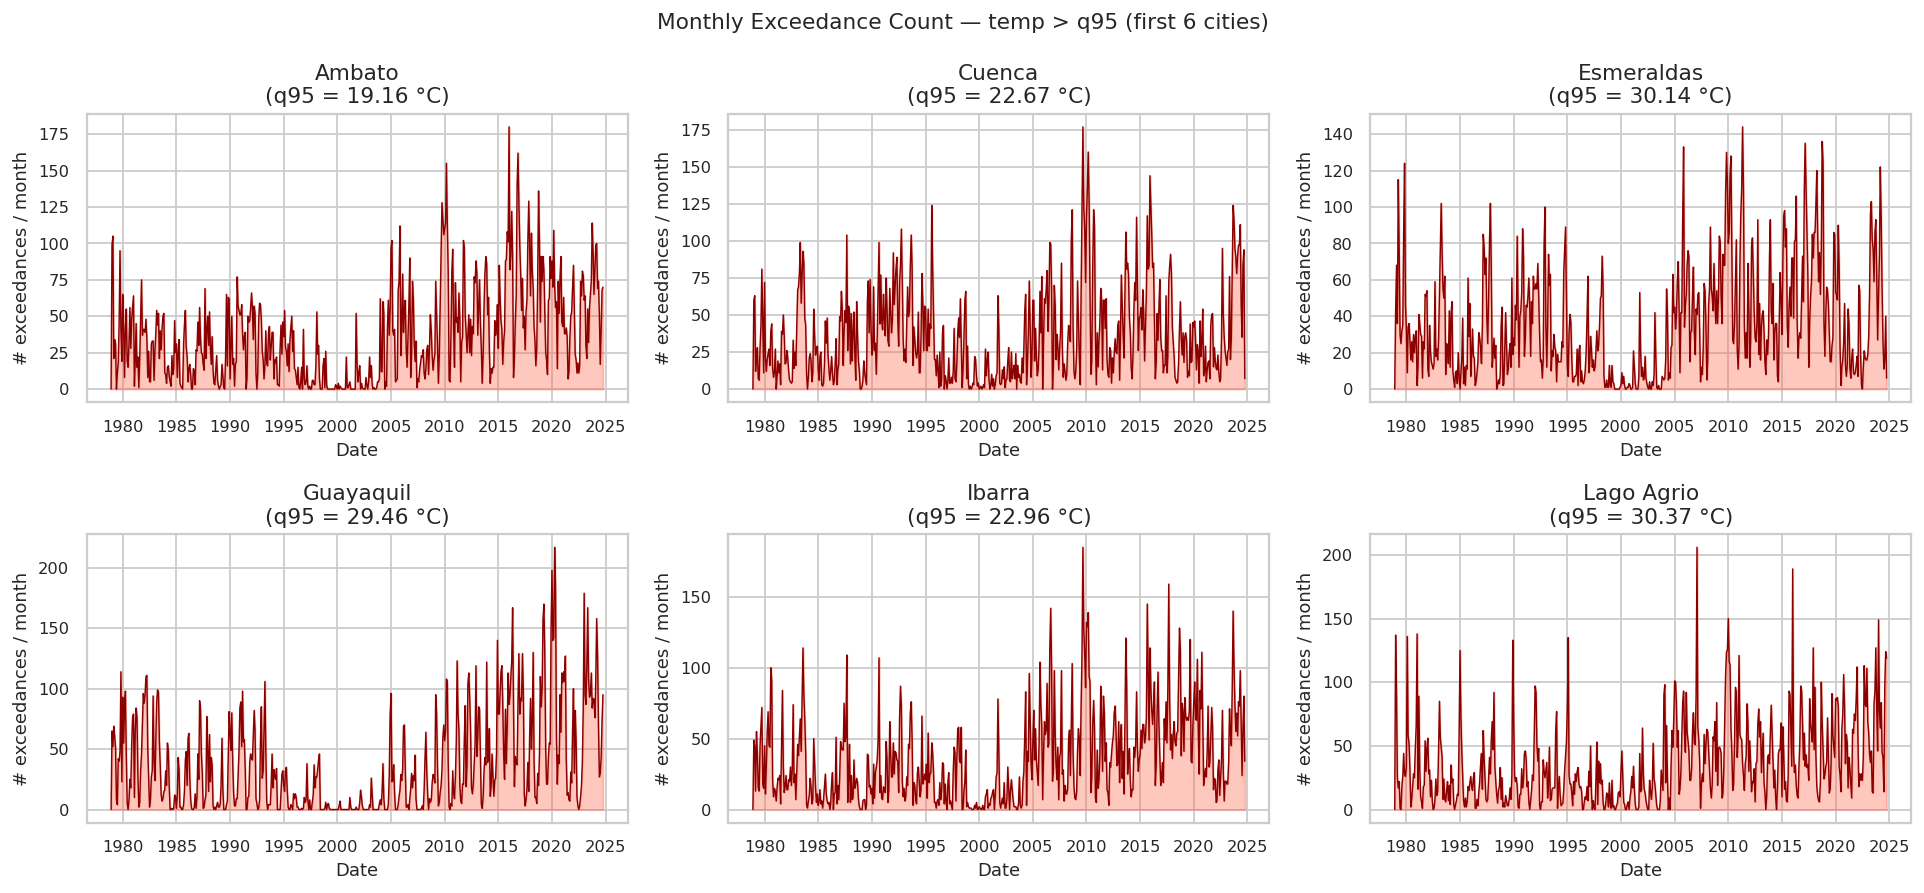

✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/figures/08_pot_exceedances_temp.png


In [ ]:
def threshold_exceedance(
    df: pd.DataFrame, city: str, var: str, q: float = 0.95
) -> Optional[Tuple[float, pd.DataFrame]]:
    """Monthly count of observations exceeding the q-th empirical quantile."""
    g = df.loc[df['city_name'] == city, ['fecha_local', var]].dropna()
    if g.empty:
        return None
    thr = float(g[var].quantile(q))
    g   = g.copy()
    g['exceed'] = (g[var] > thr).astype(int)
    g['year']   = g['fecha_local'].dt.year
    g['month']  = g['fecha_local'].dt.month
    monthly = g.groupby(['year','month'])['exceed'].sum().reset_index()
    monthly['date'] = pd.to_datetime(
        dict(year=monthly['year'], month=monthly['month'], day=1)
    )
    return thr, monthly.sort_values('date')


# ── Plot first 6 cities × temperature ────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(15, 7), sharey=False)
axes = axes.flatten()

with tqdm(enumerate(cities_6), total=6, desc='POT plots (temp)') as pbar:
    for i, city in pbar:
        res = threshold_exceedance(df, city, 'temp', q=0.95)
        if res is None:
            axes[i].set_visible(False)
            continue
        thr, monthly = res
        ax = axes[i]
        ax.fill_between(monthly['date'], monthly['exceed'],
                        alpha=0.35, color='tomato')
        ax.plot(monthly['date'], monthly['exceed'],
                linewidth=0.8, color='darkred')
        ax.set_title(f'{city}\n(q95 = {thr:.2f} °C)')
        ax.set_xlabel('Date')
        ax.set_ylabel('# exceedances / month')

fig.suptitle('Monthly Exceedance Count — temp > q95 (first 6 cities)', fontsize=12)
plt.tight_layout()
plt.savefig(FIG_DIR / '08_pot_exceedances_temp.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'✅ Saved → {FIG_DIR}/08_pot_exceedances_temp.png')

In [ ]:
# ── All-city × all-EVT-var exceedance summary ─────────────────────────────────
exc_rows = []

with tqdm(df['city_name'].cat.categories, desc='Exceedance summary', unit='city') as pbar:
    for city in pbar:
        for var in [v for v in EVT_VARS if v in df.columns]:
            res = threshold_exceedance(df, city, var, q=0.95)
            if res is None:
                continue
            thr, monthly = res
            exc_rows.append({
                'city_name'                 : city,
                'variable'                  : var,
                'q95_threshold'             : round(thr, 3),
                'total_exceedance_hours'    : int(monthly['exceed'].sum()),
                'mean_exceedances_per_month': round(monthly['exceed'].mean(), 2),
            })

exc_summary = pd.DataFrame(exc_rows)

pivot_exc = exc_summary.pivot_table(
    index='city_name', columns='variable',
    values='mean_exceedances_per_month',
)
print('Mean monthly exceedances (q95) per city × variable:')
display(
    pivot_exc.style
        .background_gradient(cmap='Reds')
        .format('{:.1f}')
)

exc_summary.to_csv(TBL_DIR / 'exceedance_summary.csv', index=False)
print(f'\n✅ Saved → {TBL_DIR}/exceedance_summary.csv')

Exceedance summary:   0%|          | 0/16 [00:00<?, ?city/s]

Mean monthly exceedances (q95) per city × variable:



✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/tables/exceedance_summary.csv


---
## § 9 · Correlation Analysis

Correlations between meteorological variables help:
- Identify redundant predictors (e.g., `temp` ↔ `feels_like` ≈ 0.99)
- Select independent covariates for non-stationary GEV models
- Detect physically plausible relationships (e.g., `temp` ↑ → `dew_point` ↑, `humidity` ↓)

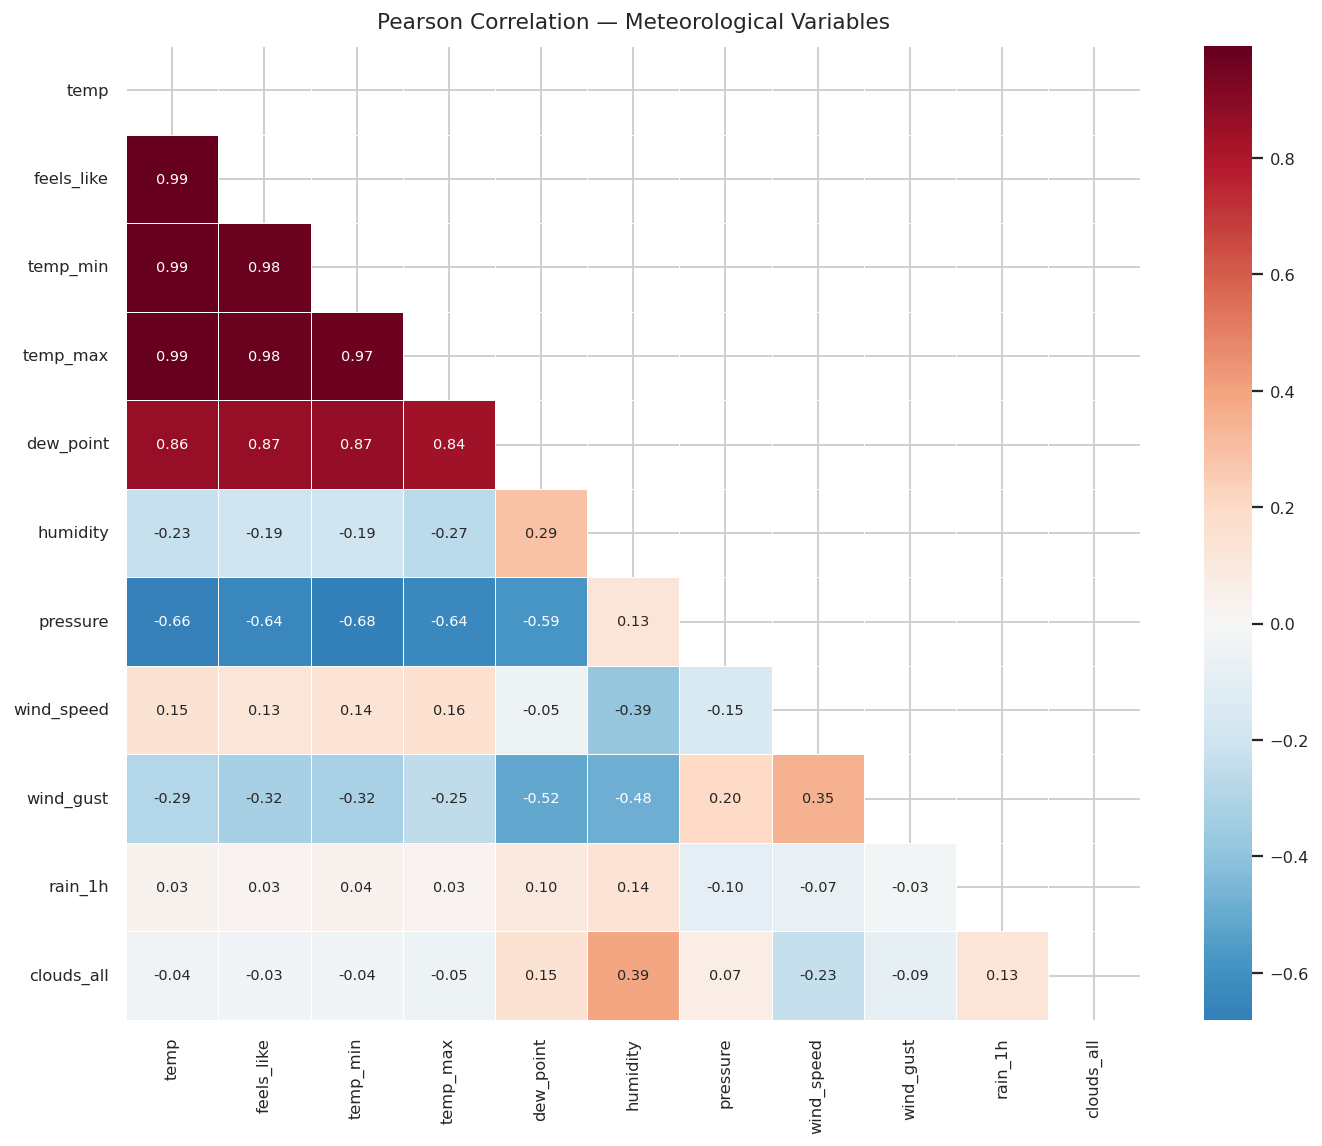

✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/figures/09_correlation_heatmap.png


In [ ]:
# ── 9.1  Pearson correlation heatmap ─────────────────────────────────────────
corr_vars = [
    c for c in ['temp','feels_like','temp_min','temp_max','dew_point',
                'humidity','pressure','wind_speed','wind_gust','rain_1h','clouds_all']
    if c in df.columns and df[c].notna().sum() > 10_000
]
corr = df[corr_vars].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(
    corr, mask=mask, annot=True, fmt='.2f',
    cmap='RdBu_r', center=0, linewidths=0.5,
    ax=ax, annot_kws={'size': 8},
)
ax.set_title('Pearson Correlation — Meteorological Variables', pad=10)
plt.tight_layout()
plt.savefig(FIG_DIR / '09_correlation_heatmap.png', dpi=150)
plt.show()
print(f'✅ Saved → {FIG_DIR}/09_correlation_heatmap.png')

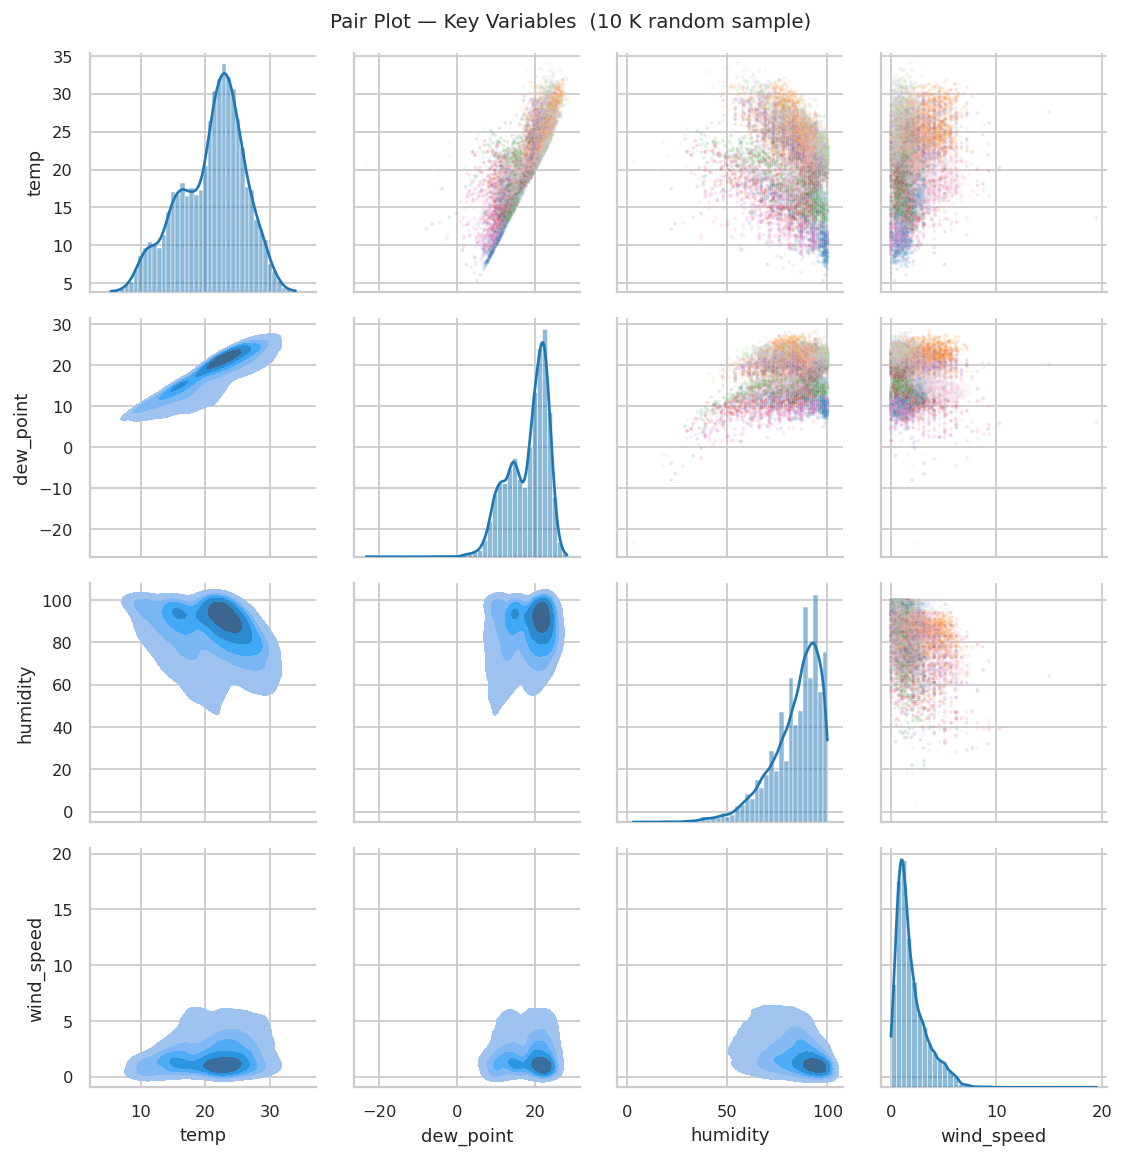

✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/figures/09_pair_plot.png


In [ ]:
# ── 9.2  Pair-plot (10 K sample) ─────────────────────────────────────────────
scatter_vars = [v for v in ['temp','dew_point','humidity','wind_speed'] if v in df.columns]
sample_sc    = df[scatter_vars + ['city_name']].sample(10_000, random_state=42).dropna()

g = sns.PairGrid(sample_sc, vars=scatter_vars, diag_sharey=False, height=2.2)
g.map_upper(
    sns.scatterplot,
    alpha=0.15, s=4,
    hue=sample_sc['city_name'], palette='tab20', legend=False,
)
g.map_lower(sns.kdeplot, fill=True, thresh=0.05, levels=6)
g.map_diag(sns.histplot, bins=40, kde=True)
g.figure.suptitle('Pair Plot — Key Variables  (10 K random sample)', y=1.01, fontsize=11)
plt.savefig(FIG_DIR / '09_pair_plot.png', dpi=130, bbox_inches='tight')
plt.show()
print(f'✅ Saved → {FIG_DIR}/09_pair_plot.png')

---
## § 10 · Categorical Variables — Weather Conditions

Weather category (`weather_main`) is a useful **covariate** for conditional EVT models —  
e.g., fitting separate GEV parameters for "Rain" vs. "Clear" sub-populations.

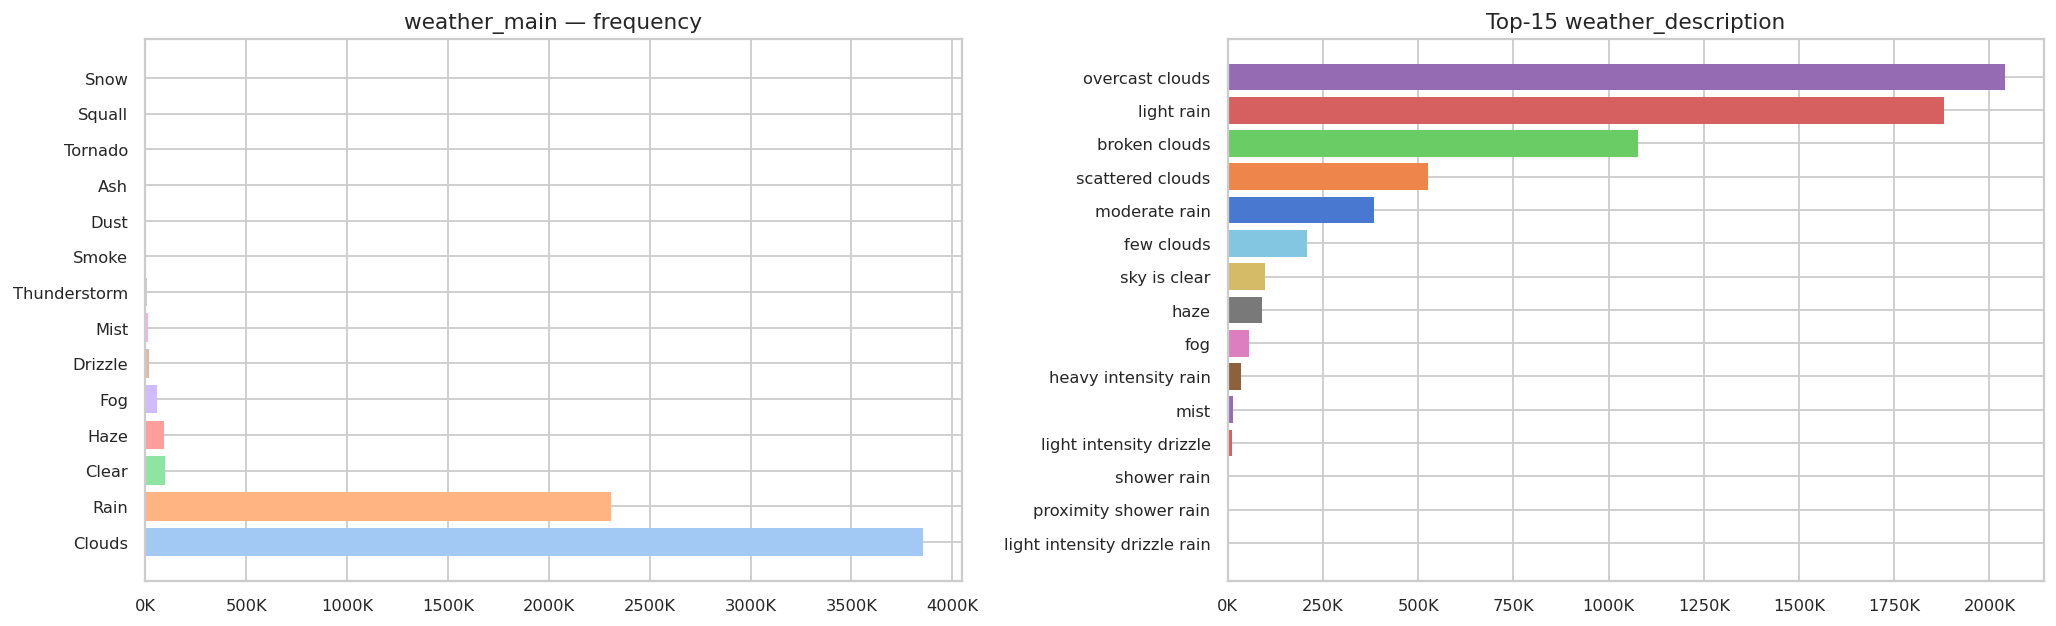

✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/figures/10_weather_categories.png


In [ ]:
# ── 10.1  Global weather_main & weather_description frequency ────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

wm = df['weather_main'].value_counts()
axes[0].barh(
    wm.index, wm.values,
    color=sns.color_palette('pastel', len(wm)), edgecolor='none',
)
axes[0].set_title('weather_main — frequency')
axes[0].xaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f'{int(x/1e3)}K')
)

wd = df['weather_description'].value_counts().head(15)
axes[1].barh(
    wd.index[::-1], wd.values[::-1],
    color=sns.color_palette('muted', len(wd)), edgecolor='none',
)
axes[1].set_title('Top-15 weather_description')
axes[1].xaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f'{int(x/1e3)}K')
)

plt.tight_layout()
plt.savefig(FIG_DIR / '10_weather_categories.png', dpi=150)
plt.show()
print(f'✅ Saved → {FIG_DIR}/10_weather_categories.png')

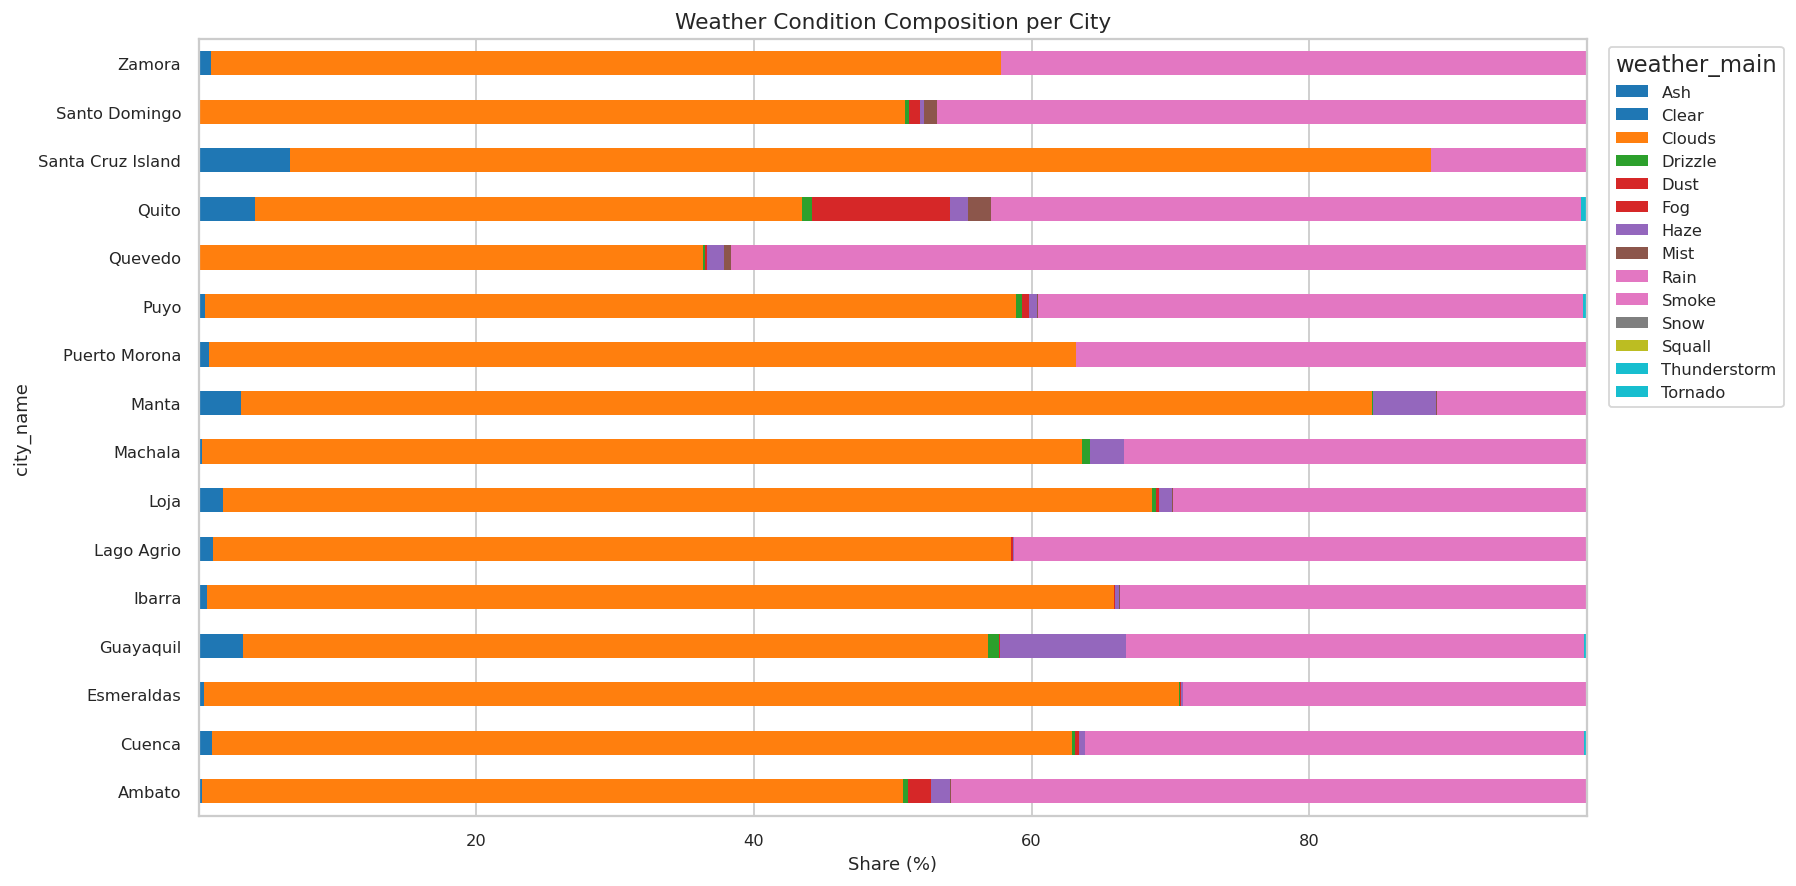

✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/figures/10_weather_composition_by_city.png


In [ ]:
# ── 10.2  Weather composition per city (stacked %) ───────────────────────────
wm_city = (
    df.groupby(['city_name','weather_main'], observed=True)
      .size()
      .unstack(fill_value=0)
)
wm_pct = wm_city.div(wm_city.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(14, 7))
wm_pct.plot.barh(stacked=True, ax=ax, colormap='tab10', edgecolor='none')
ax.set_xlabel('Share (%)')
ax.set_title('Weather Condition Composition per City')
ax.legend(title='weather_main', bbox_to_anchor=(1.01, 1),
          loc='upper left', fontsize=9)
plt.tight_layout()
plt.savefig(FIG_DIR / '10_weather_composition_by_city.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'✅ Saved → {FIG_DIR}/10_weather_composition_by_city.png')

---
## § 11 · Spatial Overview

Cities are plotted at their centroid coordinates, coloured by mean temperature  
and sized proportionally to mean `rain_1h`.  
The equator reference line (0°) confirms that all cities lie within ±5° latitude.

Expected gradient:
- **Coastal / Amazon basin** (Esmeraldas, Manta, Guayaquil, Puyo, Lago Agrio) — warm & humid
- **Andean sierra** (Quito, Ambato, Cuenca, Loja) — cooler at elevation
- **Galápagos** (Santa Cruz Island) — mild oceanic

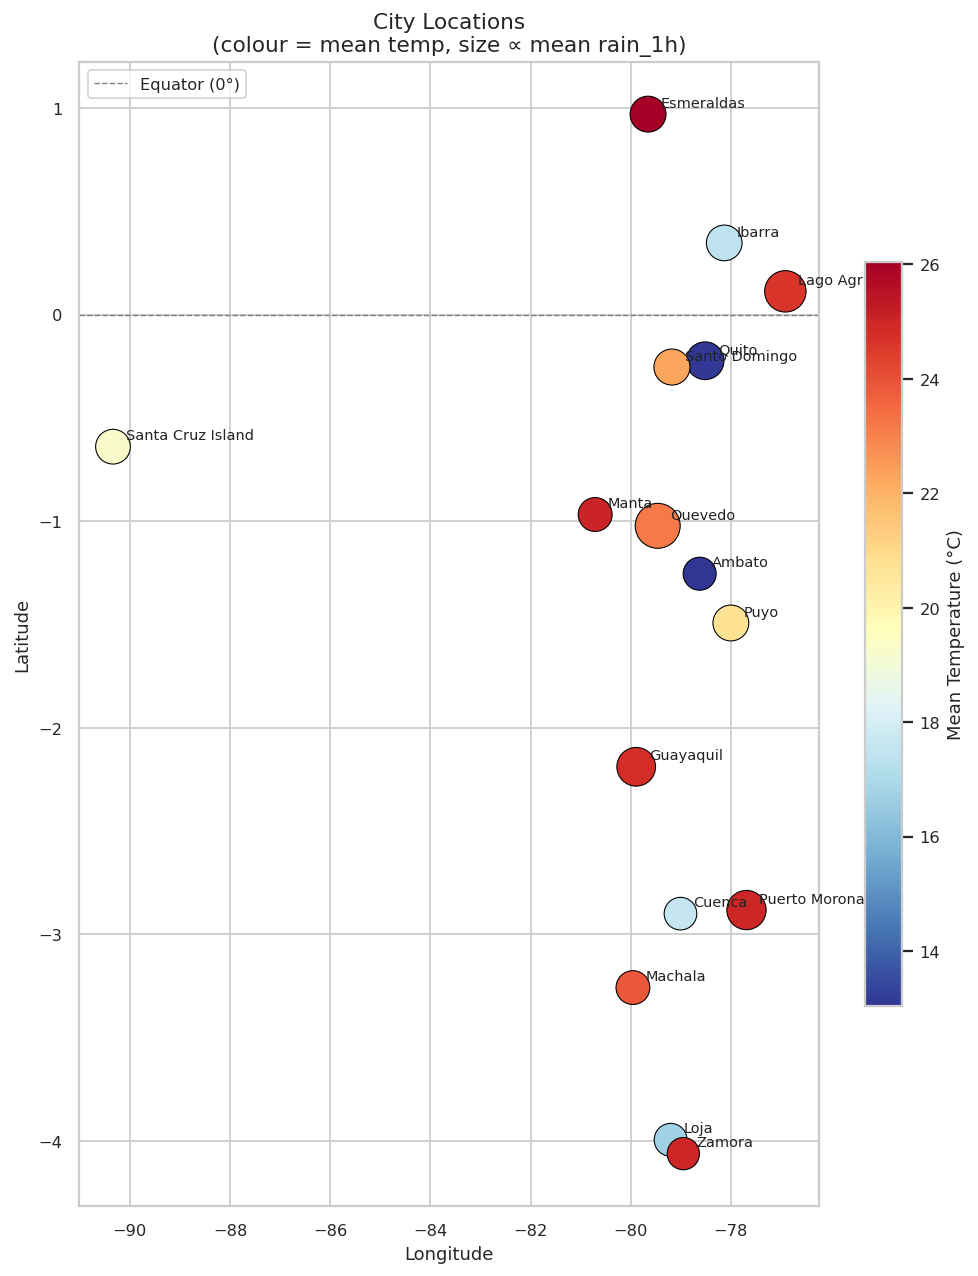

✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/figures/11_spatial_map.png
✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/tables/city_geo_stats.csv


In [ ]:
city_geo = (
    df.groupby('city_name', observed=True)
      .agg(
          lat      =('lat','mean'),
          lon      =('lon','mean'),
          mean_temp=('temp','mean'),
          max_temp =('temp','max'),
          mean_rain=('rain_1h','mean'),
      )
      .reset_index()
)

fig, ax = plt.subplots(figsize=(8, 10))
sc = ax.scatter(
    city_geo['lon'], city_geo['lat'],
    c=city_geo['mean_temp'], cmap='RdYlBu_r',
    s=city_geo['mean_rain'].fillna(0) * 500 + 80,
    edgecolors='black', linewidths=0.6, zorder=3,
)
plt.colorbar(sc, ax=ax, label='Mean Temperature (°C)', shrink=0.65)
for _, row in city_geo.iterrows():
    ax.annotate(
        row['city_name'], (row['lon'], row['lat']),
        textcoords='offset points', xytext=(7, 4),
        fontsize=8, color='#222',
    )
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8, label='Equator (0°)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('City Locations\n(colour = mean temp, size ∝ mean rain_1h)')
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig(FIG_DIR / '11_spatial_map.png', dpi=150)
plt.show()
print(f'✅ Saved → {FIG_DIR}/11_spatial_map.png')

city_geo.to_csv(TBL_DIR / 'city_geo_stats.csv', index=False)
print(f'✅ Saved → {TBL_DIR}/city_geo_stats.csv')

---
## § 12 · Long-term Trend Inspection

**Why this matters for EVT:**  
A statistically significant upward trend in mean temperature implies that the GEV location parameter  
is non-stationary (μ = μ₀ + μ₁·t).  Fitting a stationary GEV to non-stationary data yields biased  
return-level estimates.

We report:
- Annual mean temperature per city with a 5-year rolling mean
- OLS slope in °C/year + p-value (significance threshold p < 0.05)

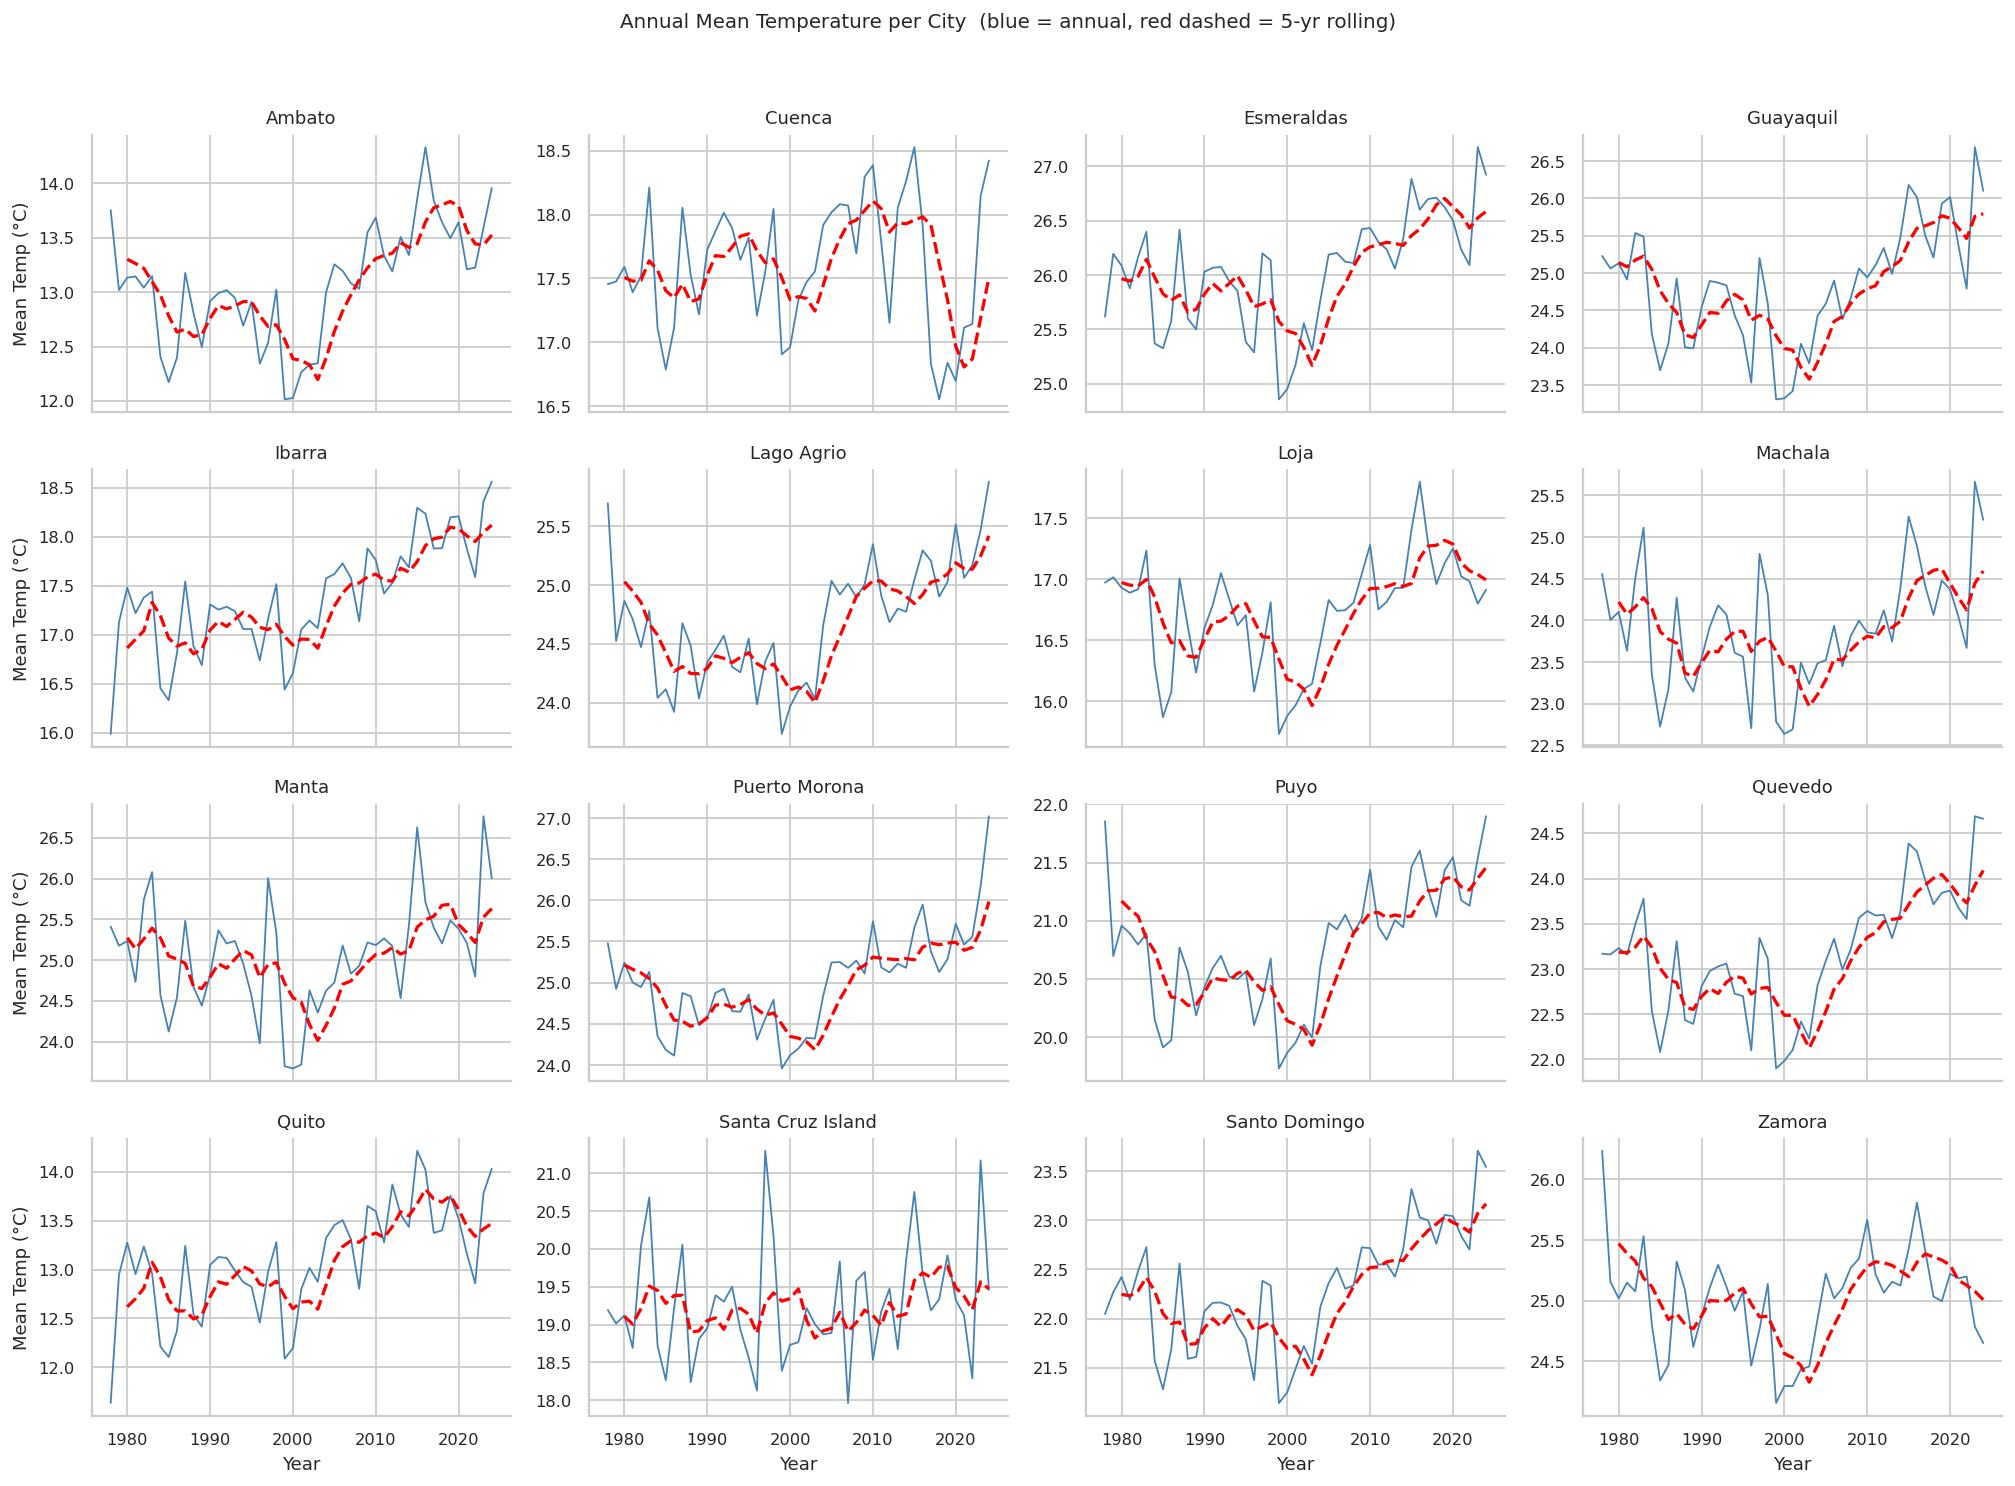

✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/figures/12_long_term_temp_trend.png


In [ ]:
# ── 12.1  Annual means ─────────────────────────────────────────────────────────
annual_mean = (
    df.groupby(['city_name','year'], observed=True)
      .agg(mean_temp=('temp','mean'), max_temp=('temp','max'))
      .reset_index()
)

def _plot_trend(x, y, **kwargs):
    """Helper for FacetGrid: raw series (blue) + 5-yr rolling mean (red dashed)."""
    ax = plt.gca()
    # Filter out extra kwargs seaborn passes (e.g. 'color' from hue)
    clean_kw = {k: v for k, v in kwargs.items() if k not in ('color',)}
    ax.plot(x, y, linewidth=1.0, color='steelblue', **clean_kw)
    s = pd.Series(y.values, index=x.values).sort_index()
    ax.plot(s.index, s.rolling(5, min_periods=3).mean(),
            color='red', linewidth=1.8, linestyle='--')


g = sns.FacetGrid(annual_mean, col='city_name', col_wrap=4,
                  height=2.8, sharey=False, aspect=1.4)
g.map(_plot_trend, 'year', 'mean_temp')
g.set_axis_labels('Year', 'Mean Temp (°C)')
g.set_titles(col_template='{col_name}')
g.figure.suptitle(
    'Annual Mean Temperature per City  (blue = annual, red dashed = 5-yr rolling)',
    y=1.02, fontsize=11,
)
plt.tight_layout()
plt.savefig(FIG_DIR / '12_long_term_temp_trend.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'✅ Saved → {FIG_DIR}/12_long_term_temp_trend.png')

In [ ]:
# ── 12.2  OLS trend test per city ────────────────────────────────────────────
trend_rows = []

with tqdm(df['city_name'].cat.categories, desc='OLS trend test', unit='city') as pbar:
    for city in pbar:
        sub = annual_mean[annual_mean['city_name'] == city].dropna(subset=['mean_temp'])
        if len(sub) < 5:
            continue
        slope, _, r, p, se = sp_stats.linregress(sub['year'], sub['mean_temp'])
        trend_rows.append({
            'city_name'   : city,
            'slope_°C/yr' : round(float(slope), 4),
            'r'           : round(float(r),     3),
            'p_value'     : round(float(p),     4),
            'significant' : '⚠️ YES' if p < 0.05 else 'no',
        })

trend_df = pd.DataFrame(trend_rows).sort_values('slope_°C/yr', ascending=False)

print('OLS trend in annual mean temperature per city:')
display(
    trend_df.style
        .bar(subset=['slope_°C/yr'], align='zero', color=['#c0392b','#27ae60'])
        .map(
            lambda v: 'color: red; font-weight: bold' if v == '⚠️ YES' else '',
            subset=['significant'],
        )
)

trend_df.to_csv(TBL_DIR / 'long_term_trend.csv', index=False)
print(f'\n✅ Saved → {TBL_DIR}/long_term_trend.csv')

OLS trend test:   0%|          | 0/16 [00:00<?, ?city/s]

OLS trend in annual mean temperature per city:



✅ Saved → /content/drive/MyDrive/extreme-climate-forecasting/EDA/tables/long_term_trend.csv


---
## § 13 · EDA Report Export

All tables and figures are saved to:
```
/content/drive/MyDrive/extreme-climate-forecasting/EDA/
├── figures/   ← 18 PNG files (numbered by section)
└── tables/    ← 10 CSV tables + figure_index.csv
```

In [ ]:
# ── 13.1  Export all CSV tables ──────────────────────────────────────────────
tables_to_save = {
    'missingness.csv'               : miss,
    'city_missingness_evt_vars.csv' : city_miss.reset_index(),
    'city_temporal_coverage.csv'    : city_temporal.reset_index(),
    'max_gap_per_city.csv'          : gap_df,
    'duplicate_timestamps.csv'      : dup_df,
    'evt_tail_quantiles.csv'        : evt_df.reset_index(),
    'exceedance_summary.csv'        : exc_summary,
    'city_geo_stats.csv'            : city_geo,
    'long_term_trend.csv'           : trend_df,
    'timezone_distribution.csv'     : tz_dist,
}

for fname, tbl in tables_to_save.items():
    path = TBL_DIR / fname
    tbl.to_csv(path, index=False)
    print(f'  ✅  {path}')

print('\nAll tables saved.')

  ✅  /content/drive/MyDrive/extreme-climate-forecasting/EDA/tables/missingness.csv
  ✅  /content/drive/MyDrive/extreme-climate-forecasting/EDA/tables/city_missingness_evt_vars.csv
  ✅  /content/drive/MyDrive/extreme-climate-forecasting/EDA/tables/city_temporal_coverage.csv
  ✅  /content/drive/MyDrive/extreme-climate-forecasting/EDA/tables/max_gap_per_city.csv
  ✅  /content/drive/MyDrive/extreme-climate-forecasting/EDA/tables/duplicate_timestamps.csv
  ✅  /content/drive/MyDrive/extreme-climate-forecasting/EDA/tables/evt_tail_quantiles.csv
  ✅  /content/drive/MyDrive/extreme-climate-forecasting/EDA/tables/exceedance_summary.csv
  ✅  /content/drive/MyDrive/extreme-climate-forecasting/EDA/tables/city_geo_stats.csv
  ✅  /content/drive/MyDrive/extreme-climate-forecasting/EDA/tables/long_term_trend.csv
  ✅  /content/drive/MyDrive/extreme-climate-forecasting/EDA/tables/timezone_distribution.csv

All tables saved.


In [ ]:
# ── 13.2  Figure index ────────────────────────────────────────────────────────
fig_index = pd.DataFrame([
    {
        'filename'   : p.name,
        'section'    : p.stem[:2],
        'description': p.stem[3:].replace('_', ' '),
    }
    for p in sorted(FIG_DIR.glob('*.png'))
])
fig_index.to_csv(TBL_DIR / 'figure_index.csv', index=False)
print('Figure index:')
display(fig_index)

Figure index:


filename section                  description
0               03_missingness_bar.png      03              missingness bar
1            03_missingness_matrix.png      03           missingness matrix
2       04_annual_coverage_heatmap.png      04      annual coverage heatmap
3              04_max_gap_per_city.png      04             max gap per city
4              04_records_per_city.png      04             records per city
5              06_boxplots_by_city.png      06             boxplots by city
6              06_diurnal_patterns.png      06             diurnal patterns
7           06_histograms_all_vars.png      06          histograms all vars
8         06_monthly_temp_per_city.png      06        monthly temp per city
9             06_seasonal_patterns.png      06            seasonal patterns
10     07_annual_block_maxima_temp.png      07     annual block maxima temp
11            07_mean_excess_plots.png      07            mean excess plots
12    07_monthly_block_maxima_temp.png      07    monthly block maxima temp
13               07_survival_tails.png      07               survival tails
14         08_pot_exceedances_temp.png      08         pot exceedances temp
15          09_correlation_heatmap.png      09          correlation heatmap
16                    09_pair_plot.png      09                    pair plot
17           10_weather_categories.png      10           weather categories
18  10_weather_composition_by_city.png      10  weather composition by city
19                  11_spatial_map.png      11                  spatial map
20         12_long_term_temp_trend.png      12         long term temp trend

In [ ]:
# ── 13.3  Final EDA summary ──────────────────────────────────────────────────
sig_cities = trend_df[trend_df['significant'] == '⚠️ YES']['city_name'].tolist()

print('=' * 70)
print('  ECUADOR CLIMATE DATASET — EDA SUMMARY')
print('=' * 70)
print(f"  Rows            : {df.shape[0]:>12,}")
print(f"  Columns (raw)   : {len(EXPECTED_COLS):>12,}  (+6 engineered)")
print(f"  Cities          : {df['city_name'].nunique():>12,}")
print(f"  Date range      : {df['fecha_local'].min().date()} → {df['fecha_local'].max().date()}")
span = (df['fecha_local'].max() - df['fecha_local'].min()).days / 365.25
print(f"  Span            : {span:>11.1f} yr")
print(f"  Memory (optimised): {df.memory_usage(deep=True).sum()/1e6:>8.1f} MB")
print()
print("  Timezone encoding:")
print("    Mainland  → UTC−5  (−18 000 s)")
print("    Galápagos → UTC−6  (−21 600 s)  [Santa Cruz Island only]")
print()
print("  Missingness highlights (top 8 columns):")
for _, row in miss_nonzero.head(8).iterrows():
    pct  = row['missing_pct']
    flag = '🔴' if pct == 100 else '🟠' if pct > 50 else '🟡' if pct > 10 else '🟢'
    print(f"    {flag}  {row.name:<28s}  {pct:6.2f} % missing")
print()
print(f"  100 % null (drop before modelling): {all_null_cols}")
print()
print("  EVT readiness notes:")
print("    ✅  temp          — 0 % missing; ready for GEV block-maxima (all cities)")
print("    ✅  wind_speed    — 0 % missing; ready for GEV block-maxima (all cities)")
print("    ⚠️   rain_1h       — ~64 % missing overall; restrict to 2005+ for POT/GPD")
print("    ❌  wind_gust     — ~99 % missing; unreliable for EVT")
print("    ❌  rain_3h       — ~100 % missing; do not use")
print()
print(f"  Non-stationary temperature trend (p < 0.05): {sig_cities}")
print("    → Use time-varying GEV  μ(t) = μ₀ + μ₁·year  for these cities")
print()
print("  Duplicate timestamps: ", "none ✅" if dup_df['dup_rows'].sum() == 0
      else f"⚠️  found in {(dup_df['dup_rows']>0).sum()} cities — deduplicate before fitting")
print()
print('=' * 70)
print(f"  Figures  → {FIG_DIR}")
print(f"  Tables   → {TBL_DIR}")
print('=' * 70)

  ECUADOR CLIMATE DATASET — EDA SUMMARY
  Rows            :    6,445,858
  Columns (raw)   :           28  (+6 engineered)
  Cities          :           16
  Date range      : 1978-12-31 → 2024-10-19
  Span            :        45.8 yr
  Memory (optimised):   1237.6 MB

  Timezone encoding:
    Mainland  → UTC−5  (−18 000 s)
    Galápagos → UTC−6  (−21 600 s)  [Santa Cruz Island only]

  Missingness highlights (top 8 columns):
    🔴  sea_level                     100.00 % missing
    🔴  grnd_level                    100.00 % missing
    🔴  snow_3h                       100.00 % missing
    🔴  snow_1h                       100.00 % missing
    🟠  rain_3h                        99.98 % missing
    🟠  wind_gust                      99.12 % missing
    🟠  visibility                     83.92 % missing
    🟠  rain_1h                        64.14 % missing

  100 % null (drop before modelling): ['sea_level', 'grnd_level', 'snow_3h', 'snow_1h']

  EVT readiness notes:
    ✅  temp          — 0 

---
*End of notebook — `init_00_EDA.ipynb`*

**Next notebooks in the pipeline:**
- `02_ECF_GEV_Classical.ipynb` — GEV parameter estimation via MLE (stationary)
- `03_ECF_GPD_POT.ipynb` — Generalised Pareto / Peak-over-Threshold with declustering
- `04_ECF_GEV_Nonstationary.ipynb` — Time-varying GEV for cities flagged above
- `05_ECF_LSTM_Seq2Seq.ipynb` — Deep learning baseline for extreme-event sequence forecasting